# Прогноз температуры сплава для металлургического комбината «Стальная птица»

Металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали и хочет контролировать температуру сплава.

**Описание технологического процесса:**
1. Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
2. Из сплава выводится сера (процесс десульфурации), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют (изменяют ее состав), подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.
3. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят ее химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
4. Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

**Цель бизнеса:** оптимизация производственных расходов

**Цель исследования:** построение модели для предсказания температуры сплава

**Заказчику важен следующий показатель:** значение метрики *MAE* на тестовой выборке не выше 6.8.

**Ход исследования**

Данные для исследования будут получены из семи файлов. О качестве данных ничего не известно, поэтому перед тем, как приступать к целям исследования, понадобится обзор данных. Необходимо будет проверить данные на ошибки и оценить их влияние на исследование. На этапе предобработки нужно осуществить поиск возможностей исправления всех ошибок данных, которые не приведут к искажению конечного результата. При необходимости, осуществим создание новых столбцов.

**Этапы исследования:**
1. Загрузка и обзор данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединенного датафрейма
5. Подготовка данных для обучения моделей
6. Обучение моделей машинного обучения
7. Выбор лучшей модели машинного обучения
8. Написание общего вывода

## Загрузка и обзор данных

Установим и импортируем необходимые для исследования библиотеки:

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import phik
from phik.report import plot_correlation_matrix
import time
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, PassiveAggressiveRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

Определим переменные:

In [3]:
RANDOM_STATE = 190525
TEST_SIZE = 0.25

Отключим отображение предупреждений:

In [4]:
warnings.filterwarnings('ignore')

Откроем файлы с датасетами:

In [5]:
try:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
except:
    data_arc_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')

Выведем первые строки датафрейма `data_arc_new`:

In [6]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Датафрейм содержит данные об электродах:
* `key` - номер партии
* `Начало нагрева дугой` - время начала нагрева
* `Конец нагрева дугой` - время окончания нагрева
* `Активная мощность` - значение активной мощности
* `Реактивная мощность` - значение реактивной мощности

In [7]:
try:
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
except:
    data_bulk_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')

Выведем первые строки датафрейма `data_bulk_new`:

In [8]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Датафрейм содержит данные о подаче сыпучих материалов (объем):
* `key` - номер партии
* `Bulk 1` … `Bulk 15` - объем подаваемого материала

In [9]:
try:
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
except:
    data_bulk_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')

Выведем первые строки датафрейма `data_bulk_time_new`:

In [10]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Датафрейм содержит данные о подаче сыпучих материалов (время):
* `key` - номер партии
* `Bulk 1` … `Bulk 15` - время подачи материала

In [11]:
try:
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
except:
    data_gas_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')

Выведем первые строки датафрейма `data_gas_new`:

In [12]:
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Датафрейм содержит данные о продувке сплава газом:
* `key` - номер партии
* `Газ 1` - объем подаваемого газа

In [13]:
try:
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
except:
    data_temp_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')

Выведем первые строки датафрейма `data_temp_new`:

In [14]:
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Датафрейм содержит результаты измерения температуры:
* `key` - номер партии
* `Время замера` - время замера
* `Температура` - значение температуры

In [15]:
try:
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
except:
    data_wire_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')

Выведем первые строки датафрейма `data_wire_new`:

In [16]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датафрейм содержит данные о проволочных материалах (объем):
* `key` - номер партии
* `Wire 1` … `Wire 9` - объем подаваемых проволочных материалов

In [17]:
try:
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_wire_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

Выведем первые строки датафрейма `data_wire_time_new`:

In [18]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датафрейм содержит данные о проволочных материалах (время):
* `key` - номер партии
* `Wire 1` … `Wire 9` - время подачи проволочных материалов

Во всех файлах столбец `key` содержит номер партии. В файлах несколькими строками с одинаковым значением `key` обозначаются разные итерации обработки.

## Исследовательский анализ и предобработка данных

Проведем исследовательский анализ каждого датафрейма и при необходимости выполним предобработку данных. Работа будет заключаться в следующем:
* Переименование столбцов
* Отображение общей информации о данных
* Графическое представление данных
* Проверка данных на аномалии
* Корректировка типов данных
* Заполнение пропусков
* Удаление дубликатов

Определим функцию для отображения информации о датафрейме:

In [19]:
def get_info(df):
    print(df.info())
    print(100 * '-')
    display(df.describe().T)

Для отображения количественных признаков из датафрейма в виде гистограмм и диаграмм размаха ("ящик с усами") определим функцию:

In [20]:
def show_graph(data, column, hist_title, box_title, xlabel):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    histplot = sns.histplot(
        data=data,
        x=column,
        bins=100,
        color='darkcyan',
        kde=True,
        ax=axes[0]
    )
    histplot.set(
        title=hist_title,
        xlabel=xlabel,
        ylabel='Количество'
    )
    histplot.axvline(data[column].median(), c='r')
    boxplot = sns.boxplot(
        data=data,
        x=column,
        color='salmon',
        ax=axes[1]
    )
    boxplot.set(
        title=box_title,
        xlabel=xlabel
    )

Определим функцию для отоборажение столбчатой диаграммы:

In [21]:
def show_barplot(data, x, y, title, xlabel, ylabel, axhline=True, axhline_value=0.1):
    plt.figure(figsize=(14, 7))
    barplot = sns.barplot(
        data=data,
        x=x,
        y=y,
        palette='hls'
    )
    if axhline:
        barplot.axhline(axhline_value, c='r')
    barplot.set(
        title=title,
        xlabel=xlabel,
        ylabel=ylabel
    )

### Датафрейм `data_arc_new`

Произведем переименование столбцов:

In [22]:
data_arc_new.columns = [
    'key',
    'heating_start',
    'heating_end',
    'active_power',
    'reactive_power'
]

Выведем общую информацию о датафрейме `data_arc_new`:

In [23]:
get_info(data_arc_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   heating_start   14876 non-null  object 
 2   heating_end     14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
active_power,14876.0,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773
reactive_power,14876.0,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284


Пропусков в данных нет. Имееются отрицательные значения в значениях реактивной мощности. Данные в столбцах `arc_heating_start` и `arc_heating_end` необходимо привести к типу `datetime`:

In [24]:
data_arc_new['heating_start'] = pd.to_datetime(data_arc_new['heating_start'])
data_arc_new['heating_end'] = pd.to_datetime(data_arc_new['heating_end'])

Проверим типы данных:

In [25]:
data_arc_new.dtypes

key                        int64
heating_start     datetime64[ns]
heating_end       datetime64[ns]
active_power             float64
reactive_power           float64
dtype: object

Далее проверим датафрейм на наличие явных дубликатов:

In [26]:
data_arc_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено. Проверим, за какой промежуток времени представлены данные в датафрейме:

In [27]:
print(data_arc_new['heating_start'].max() - data_arc_new['heating_start'].min())

126 days 06:22:40


In [28]:
print(data_arc_new['heating_end'].max() - data_arc_new['heating_end'].min())

126 days 06:20:13


Данные представлены на 126 дней (примерно 4 месяца).

Отобразим гистограмму и "ящик с усами" для столбца `active_power`:

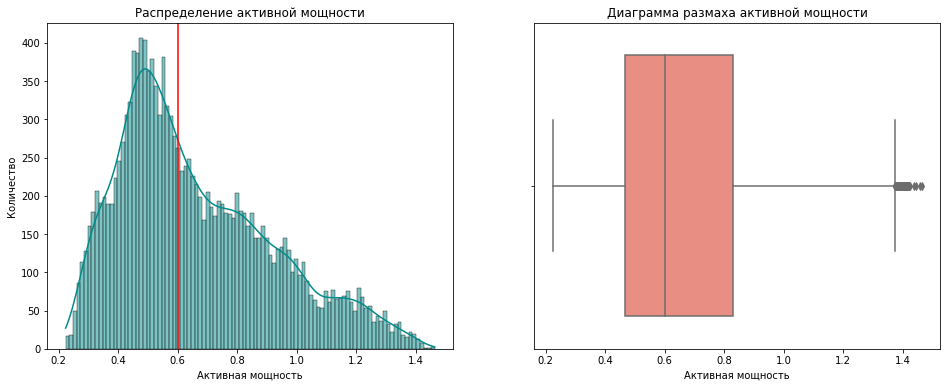

In [29]:
show_graph(
    data_arc_new,
    'active_power',
    'Распределение активной мощности',
    'Диаграмма размаха активной мощности',
    'Активная мощность'
)

Распределение активной мощности напоминает нормальное распределение с вытянутым правым хвостом. Наибольшее количество значений приходится на активную мощность около 0.6, т.е. большинство электродов работают на этой мощности. Явных аномалий в данных не отмечено.

Отобразим гистограмму и "ящик с усами" для столбца `reactive_power`:

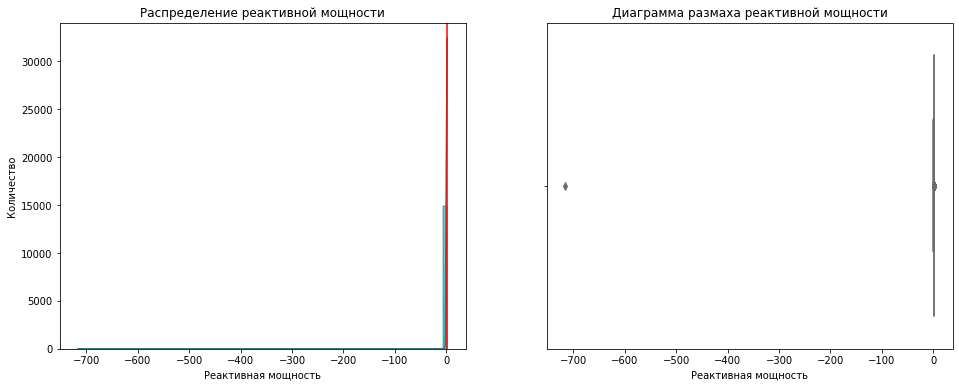

In [30]:
show_graph(
    data_arc_new,
    'reactive_power',
    'Распределение реактивной мощности',
    'Диаграмма размаха реактивной мощности',
    'Реактивная мощность'
)

Из-за отрицательных аномалий график не дает понять природу распределения данных. Выявим данные аномалии:

In [31]:
data_arc_new[data_arc_new['reactive_power'] < 0]

,key,heating_start,heating_end,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Выявлено одно отрицательное значение реактивной мощности в -715 ед. Данную аномалию можно удалить из датафрейма без потери качества в данных:

In [32]:
data_arc_new = data_arc_new[data_arc_new['reactive_power'] > 0]

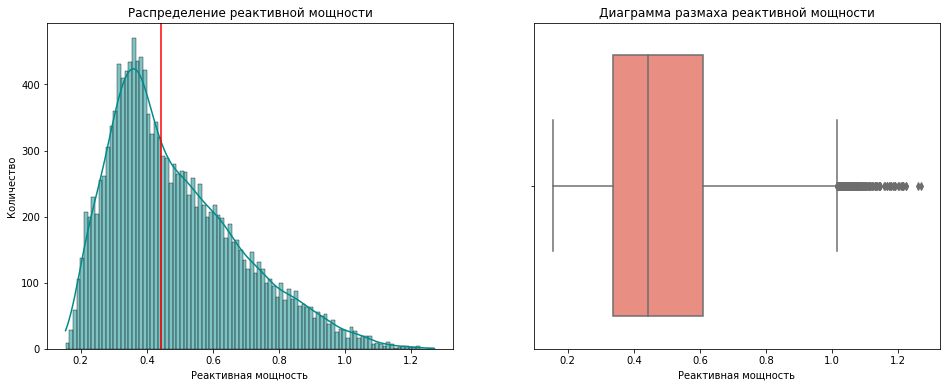

In [33]:
show_graph(
    data_arc_new,
    'reactive_power',
    'Распределение реактивной мощности',
    'Диаграмма размаха реактивной мощности',
    'Реактивная мощность'
)

Распределение реактивной мощности похоже на распределение активной мощности - напоминает нормальное распределение с вытянутым правым хвостом. Наибольшее количество значений приходится на реактивную мощность около 0.44, т.е. большинство электродов работают на этой мощности. Явных аномалий в данных не отмечено.

Добавим новый столбец с данными, которые могут быть использованы в модели машинного обучения - длительность нагрева и количество итераций нагрева:

In [34]:
data_arc_new['heating_duration'] = (data_arc_new['heating_end'] - data_arc_new['heating_start']).dt.total_seconds()
data_arc_new = data_arc_new.merge(
    data_arc_new.pivot_table(
        index='key',
        values='active_power',
        aggfunc='count'
    ).reset_index().rename(
        columns={
            'active_power': 'heating_iteration'
        }
    ),
    on='key',
    how='left'
)

Отобразим гистограмму и "ящик с усами" для столбца `heating_duration`:

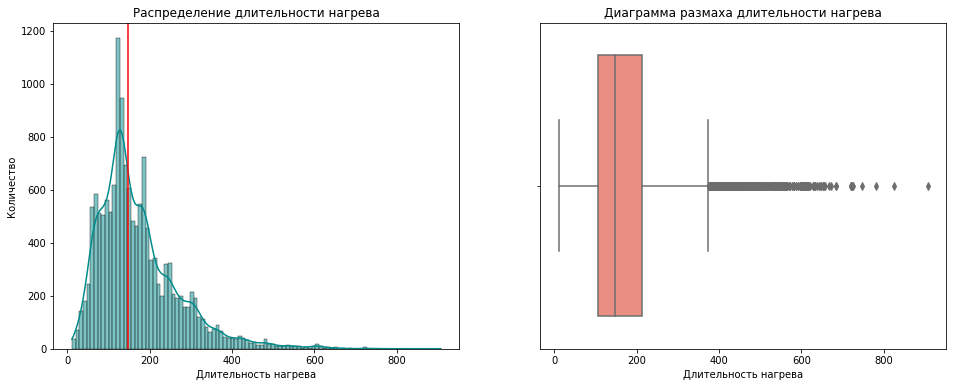

In [35]:
show_graph(
    data_arc_new,
    'heating_duration',
    'Распределение длительности нагрева',
    'Диаграмма размаха длительности нагрева',
    'Длительность нагрева'
)

Так же как и два предыдущие показателя, распределение длительности нагрева напоминает нормальное распределение с вытянутым правым хвостом. Наибольшее количество значений приходится на длительность нагрева около 147, т.е. большинство электродов работают около 2.5 минут.

Отобразим гистограмму и "ящик с усами" для столбца `heating_iteration`:

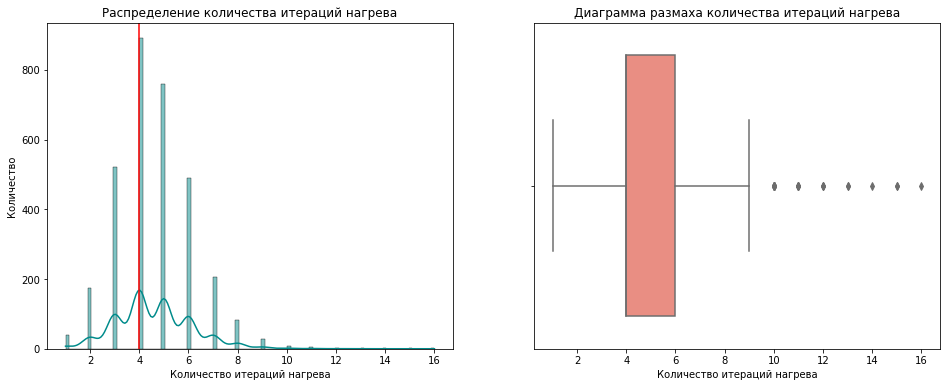

In [36]:
show_graph(
    data_arc_new.drop_duplicates(subset='key', keep='first'),
    'heating_iteration',
    'Распределение количества итераций нагрева',
    'Диаграмма размаха количества итераций нагрева',
    'Количество итераций нагрева'
)

Распределение количества итераций нагрева напоминает нормальное распределение, наибольшее количество значений приходится на количество итераций, равное 4.

Сформируем итоговый датафрейм `data_arc_new_final`:

In [37]:
data_arc_new_final = data_arc_new.groupby('key').agg(
    min_active_power = ('active_power', 'min'),
    max_active_power = ('active_power', 'max'),
    mean_active_power = ('active_power', 'mean'),
    min_reactive_power = ('reactive_power', 'min'),
    max_reactive_power = ('reactive_power', 'max'),
    mean_reactive_power = ('reactive_power', 'mean'),
    min_heating_duration = ('heating_duration', 'min'),
    max_heating_duration = ('heating_duration', 'max'),
    mean_heating_duration = ('heating_duration', 'mean'),
    heating_iteration = ('heating_iteration', 'mean')
).reset_index()

data_arc_new_final.head()

,key,min_active_power,max_active_power,mean_active_power,min_reactive_power,max_reactive_power,mean_reactive_power,min_heating_duration,max_heating_duration,mean_heating_duration,heating_iteration
0,1,0.305130,0.867133,0.607346,0.211253,0.643691,0.428564,148.0,365.0,219.60,5
1,2,0.261665,0.786322,0.534852,0.205527,0.542517,0.363339,126.0,338.0,202.75,4
2,3,0.421693,1.222963,0.812728,0.272562,0.863676,0.587491,65.0,280.0,131.00,5
3,4,0.310693,0.887855,0.676622,0.241781,0.654661,0.514248,99.0,278.0,185.25,4
4,5,0.324563,0.892957,0.563238,0.279102,0.660807,0.421998,71.0,415.0,217.25,4


### Датафрейм `data_bulk_new`

Произведем переименование столбцов:

In [38]:
data_bulk_new.columns = ['key'] + [f'bulk_{i}' for i in range(1, 16)]

Выведем общую информацию о датафрейме `data_bulk_new`:

In [39]:
get_info(data_bulk_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
bulk_1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
bulk_2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
bulk_3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
bulk_4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
bulk_5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
bulk_6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
bulk_7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
bulk_8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
bulk_9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


Типы данных в норме, но датафрейм в каждом столбце имеет пропуски в данных - возможно, этот факт связан с технологическим процессом, когда каждой партии подается определенное количество материала или не подается вовсе. Получается, что пропуски данных означают, что тот или иной сыпучий материал 1-15 не использовался в процессе производства той или иной партии. Определим долю пропусков каждого сыпучего материала:

In [40]:
pd.DataFrame(
    {
        'Доля пропусков': pd.Series(data_bulk_new.drop('key', axis=1).isna().sum() / data_bulk_new.shape[0] * 100)
    }
).sort_values(by='Доля пропусков', ascending=False)

,Доля пропусков
bulk_8,99.968041
bulk_13,99.424736
bulk_9,99.392777
bulk_2,99.296900
bulk_7,99.201023
bulk_5,97.539150
bulk_10,94.375200
bulk_11,94.343241
bulk_1,91.946309
bulk_6,81.591563


Девять из пятнадцати признаков имеют более 90% пропусков, остальные признаки имеют также значительное количество пропусков. Минимальная доля пропущенных значений составила чуть больше 10%.

Отобразим редко использующиеся в производстве сыпущие материалы:

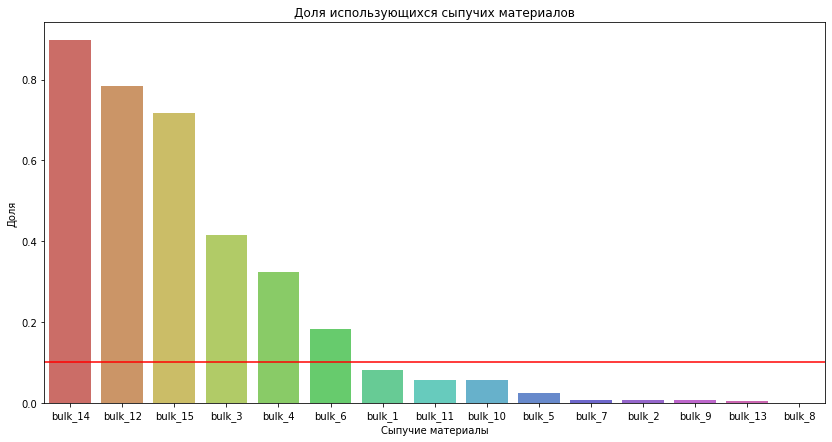

In [41]:
tmp_df = pd.DataFrame(
    {
        'Доля': (~data_bulk_new.drop('key', axis=1).isna()).mean().sort_values(ascending=False)
    }
)
tmp_df.reset_index(drop=False, inplace=True)
tmp_df.columns = ['bulk', 'prop']

show_barplot(
    tmp_df,
    'bulk',
    'prop',
    'Доля использующихся сыпучих материалов',
    'Сыпучие материалы',
    'Доля',
    True,
    0.1
)

Сыпучие материалы № 8, 13, 9, 2, 7, 5, 10, 11 и 1 используются при изготовлении менее 10% партий. В дальнейшем возможно не стоит эти данные добавлять в модель.

Далее проверим датафрейм на наличие явных дубликатов:

In [42]:
data_bulk_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено. Проверим датафрейм на дубли партий:

In [43]:
data_bulk_new['key'].value_counts().max()

1

Максимальное значение сгруппированных партий равно единице, из этого можно сделать вывод о том, что в данном датафрейме партии уникальны в каждой строке.

Проверим, чтобы все партии имели хотя бы один сыпучий материал:

In [44]:
data_bulk_new.drop('key', axis=1).sum(axis=1).min()

19.0

Минимальный объем сыпучего материала равен 19, что говорит о том, что каждая партия имеет хотя бы один сыпучий материал.

Отобразим гистограмму и "ящик с усами" для всех признаков `bulk_1` … `bulk_15`:

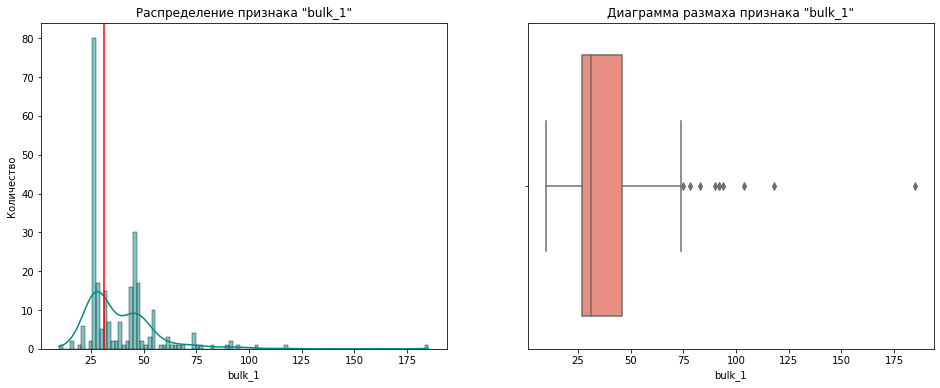

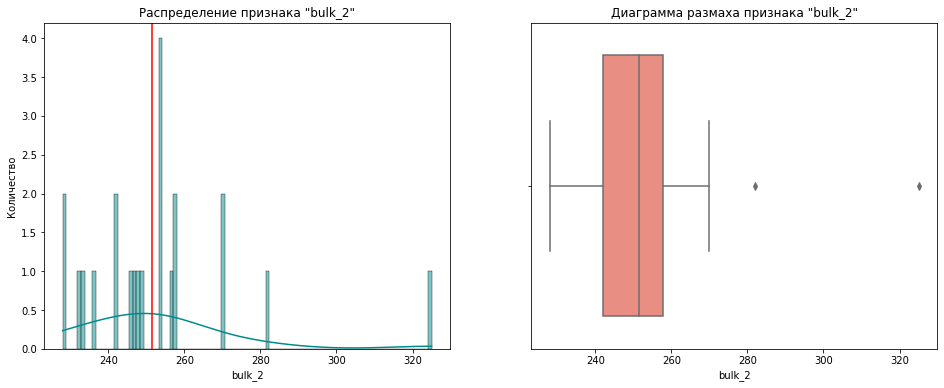

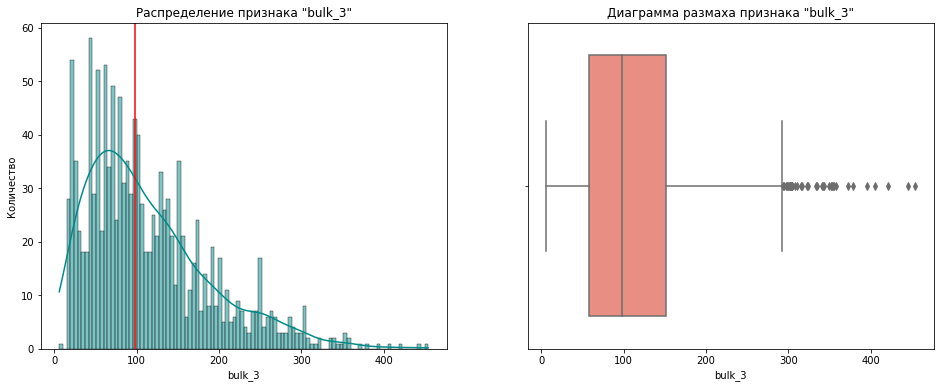

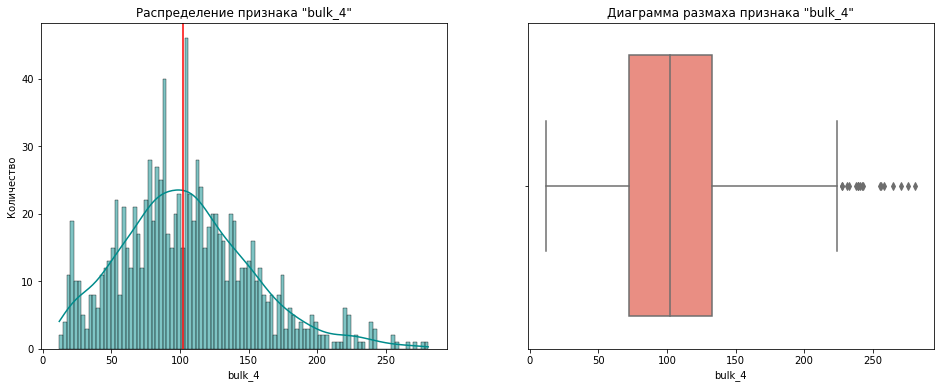

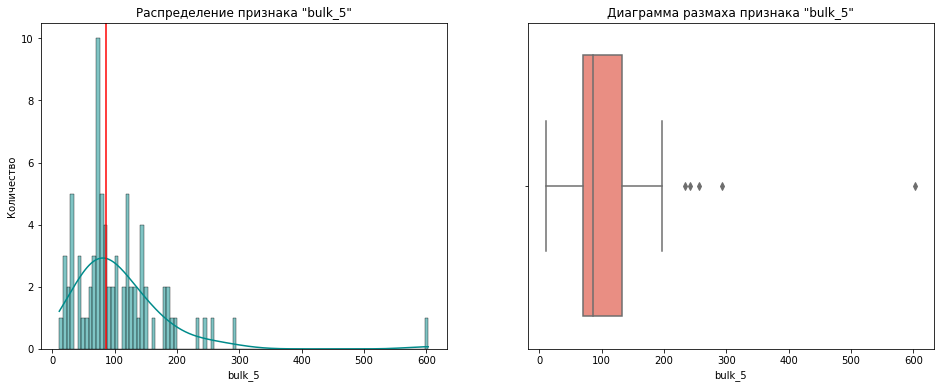

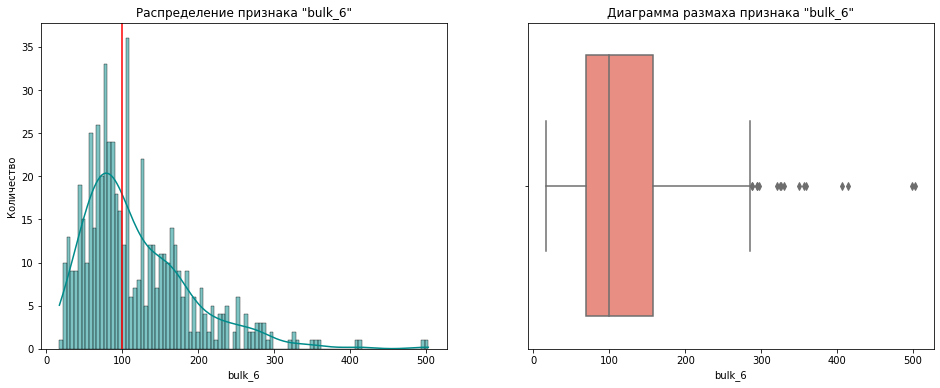

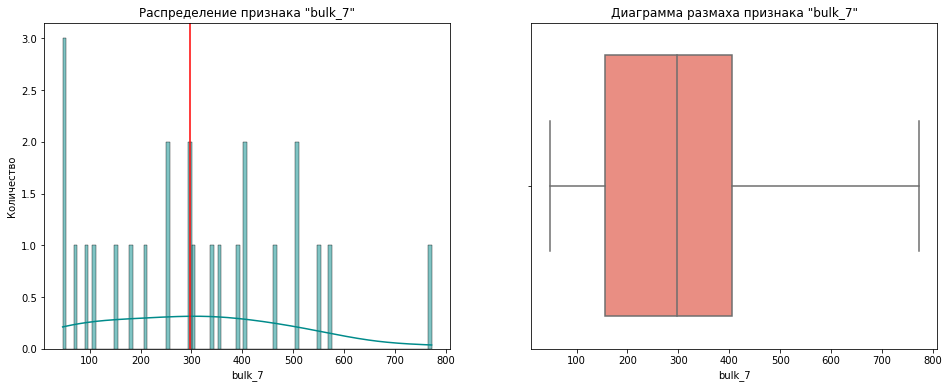

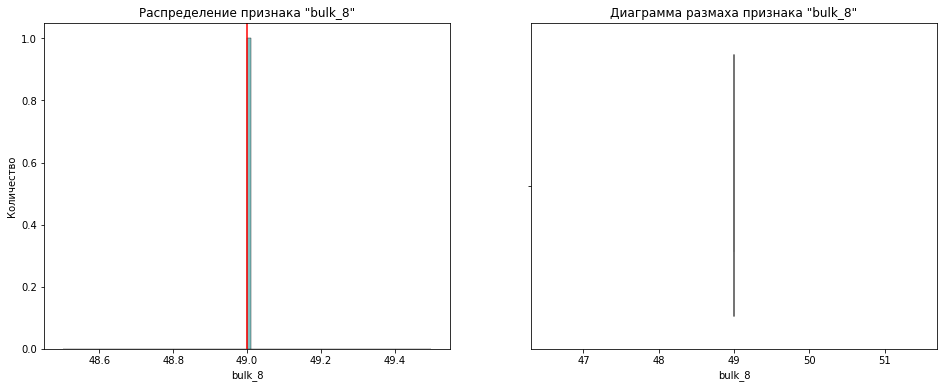

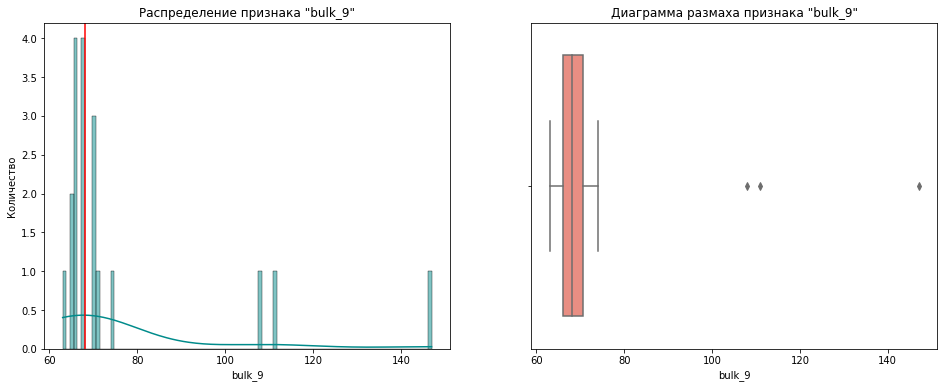

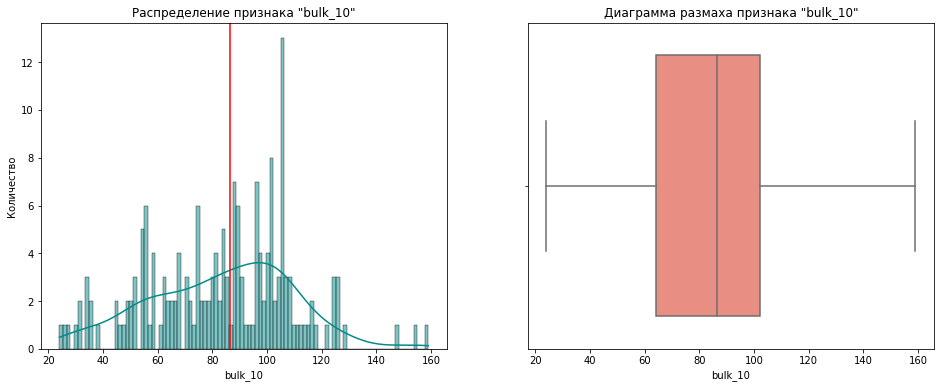

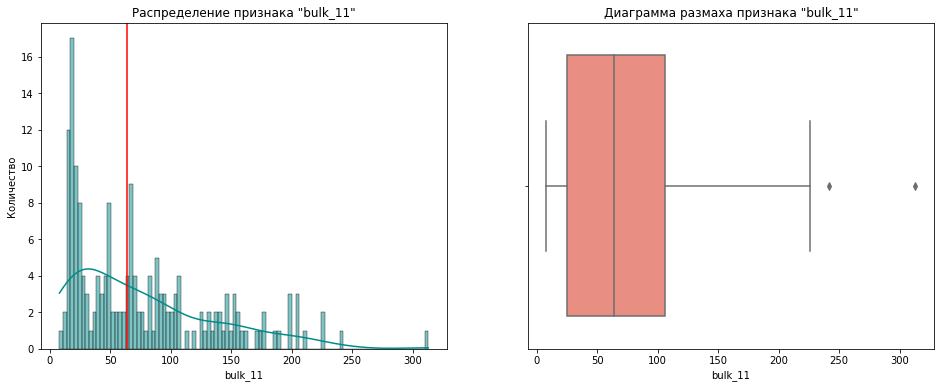

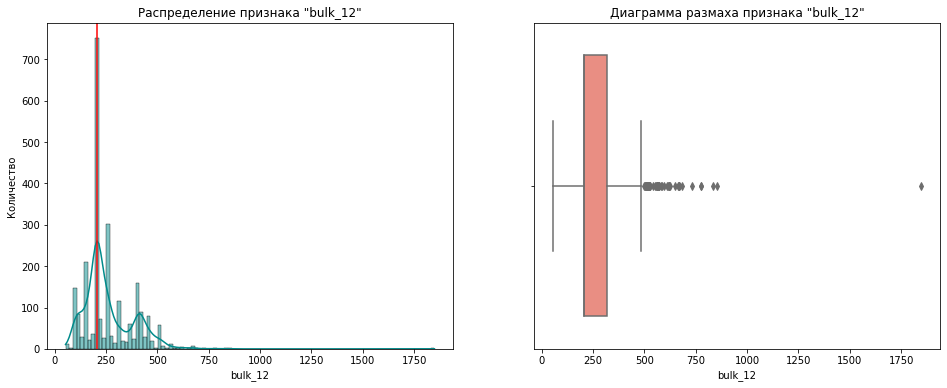

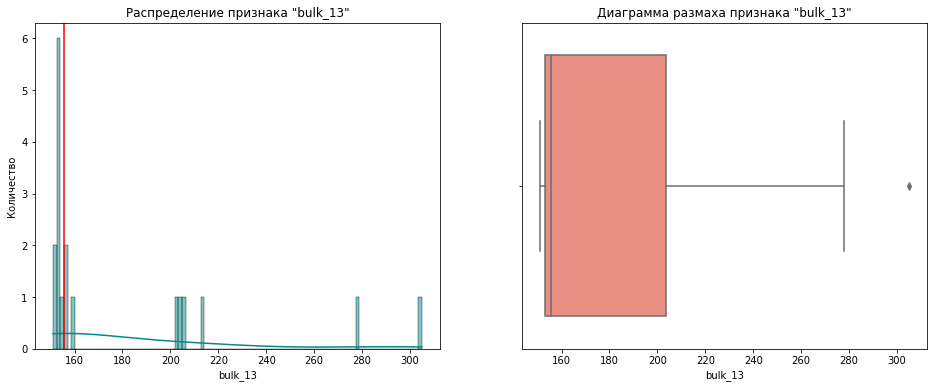

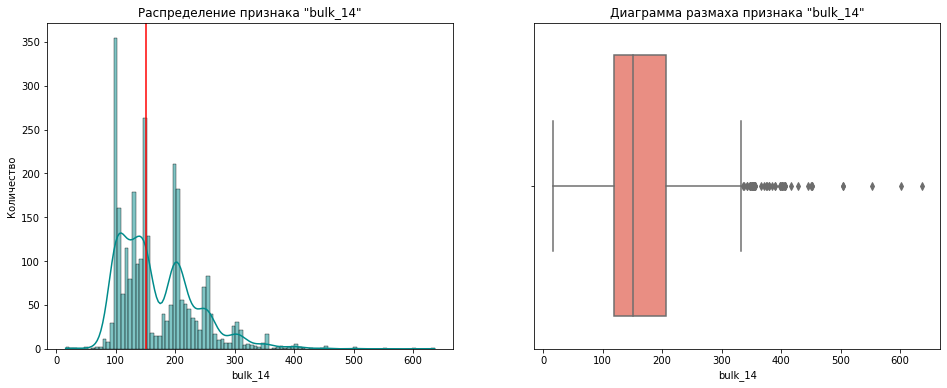

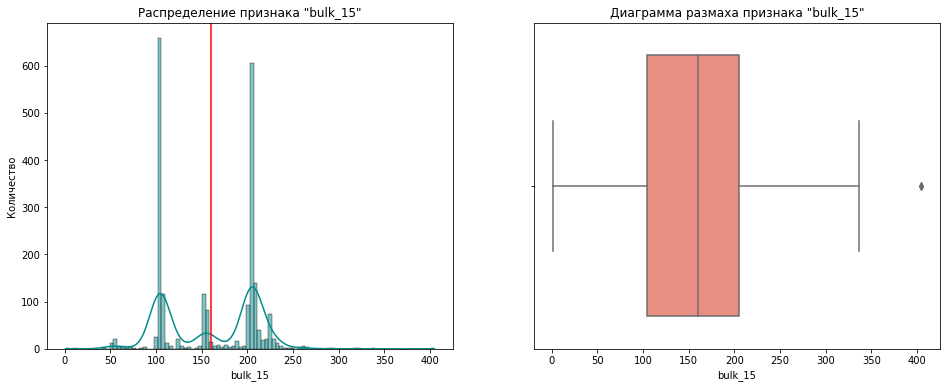

In [45]:
for i in data_bulk_new.drop('key', axis=1).columns:
    show_graph(
        data_bulk_new,
        i,
        f'Распределение признака "{i}"',
        f'Диаграмма размаха признака "{i}"',
        i
    )

Не все сыпучие материалы имеют нормальное распределение - для большинства характерны доминанты определенных значений с характерными пиками на графиках распределения. Графики распределений приближены к нормальному для сыпучих материалов № 3, 4 и 6. Обрабатывать выбросы в признаках не будем, т.к. они вполне могут соответствовать максимальным значениям.

Добавим в датафрейм суммарное значение сыпучих материалов:

In [46]:
data_bulk_new['bulk_total'] = data_bulk_new.drop('key', axis=1).sum(axis=1)

Сформируем итоговый датафрейм `data_bulk_new_final`, заменив пропуски данных на 0 (т.к. отсутствие данных по сыпучему материалу означает, что он не подавался):

In [47]:
data_bulk_new_final = data_bulk_new.fillna(0)

data_bulk_new_final.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_total
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


### Датафрейм `data_bulk_time_new`

Произведем переименование столбцов:

In [48]:
data_bulk_time_new.columns = ['key'] + [f'bulk_{i}' for i in range(1, 16)]

Выведем общую информацию о датафрейме `data_bulk_time_new`:

In [49]:
get_info(data_bulk_time_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


Очевидно, что структуры датафреймов `data_bulk_new` и `data_bulk_time_new` одинаковы: первый датафрейм отображает данные об объемах, второй - о времени подачи сыпучих материалов.

Приведем данные в столбцах `bulk_1` … `bulk_15` к типу `datetime`:

In [50]:
for i in data_bulk_time_new.drop('key', axis=1).columns:
    data_bulk_time_new[i] = pd.to_datetime(data_bulk_time_new[i])

Проверим типы данных:

In [51]:
data_bulk_time_new.dtypes

key                 int64
bulk_1     datetime64[ns]
bulk_2     datetime64[ns]
bulk_3     datetime64[ns]
bulk_4     datetime64[ns]
bulk_5     datetime64[ns]
bulk_6     datetime64[ns]
bulk_7     datetime64[ns]
bulk_8     datetime64[ns]
bulk_9     datetime64[ns]
bulk_10    datetime64[ns]
bulk_11    datetime64[ns]
bulk_12    datetime64[ns]
bulk_13    datetime64[ns]
bulk_14    datetime64[ns]
bulk_15    datetime64[ns]
dtype: object

Далее проверим датафрейм на наличие явных дубликатов:

In [52]:
data_bulk_time_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено.

На текущий момент видится нецелесообразным включение данных из датафрейма `data_bulk_time_new` в модель машиного обучения или даже формирование синтетического признака на его основе, т.к. не прослеживается четкой логической связи этих данных с целевым признаком.

### Датафрейм `data_gas_new`

Произведем переименование столбцов:

In [53]:
data_gas_new.columns = [
    'key',
    'gas'
]

Выведем общую информацию о датафрейме `data_gas_new`:

In [54]:
get_info(data_gas_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
gas,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


Пропусков в данных нет, также нет необходимости в преобразовании типов данных.

Далее проверим датафрейм на наличие явных дубликатов:

In [55]:
data_gas_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено.

Проверим датафрейм на дубли партий:

In [56]:
data_gas_new['key'].value_counts().max()

1

Максимальное значение сгруппированных партий равно единице, из этого можно сделать вывод о том, что в данном датафрейме партии уникальны в каждой строке.

Отобразим гистограмму и "ящик с усами" для столбца `Газ 1`:

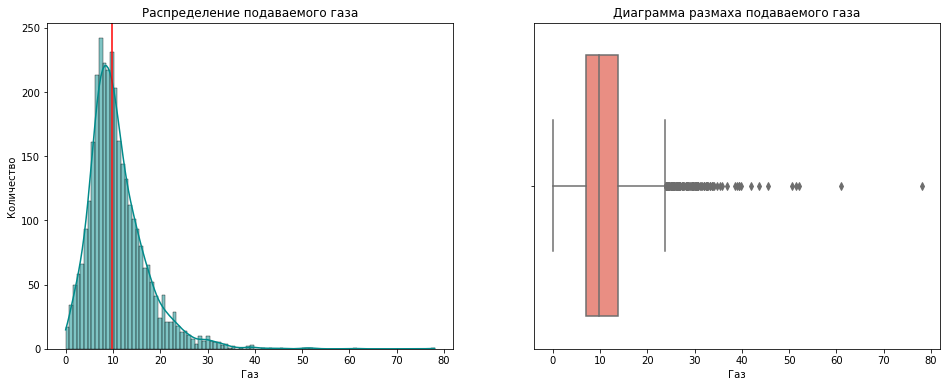

In [57]:
show_graph(
    data_gas_new,
    'gas',
    'Распределение подаваемого газа',
    'Диаграмма размаха подаваемого газа',
    'Газ'
)

Распределение данных о продувке сплава газом напоминает нормальное распределение с вытянутым правым хвостом. Наибольшее количество значений приходится на значение около 10.

### Датафрейм `data_temp_new`

Произведем переименование столбцов:

In [58]:
data_temp_new.columns = [
    'key',
    'time',
    'temperature'
]

Выведем общую информацию о датафрейме `data_temp_new`:

In [59]:
get_info(data_temp_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          18092 non-null  int64  
 1   time         18092 non-null  object 
 2   temperature  14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,18092.0,1616.460977,934.641385,1.0,807.75,1618.0,2429.0,3241.0
temperature,14665.0,1590.722741,20.394381,1191.0,1580.00,1590.0,1599.0,1705.0


Данные в столбце `Время замера` необходимо привести к типу `datetime`:

In [60]:
data_temp_new['time'] = pd.to_datetime(data_temp_new['time'])

Проверим типы данных:

In [61]:
data_temp_new.dtypes

key                     int64
time           datetime64[ns]
temperature           float64
dtype: object

Далее проверим датафрейм на наличие явных дубликатов:

In [62]:
data_temp_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено. Проверим, за какой промежуток времени представлены данные в датафрейме:

In [63]:
print(data_temp_new['time'].max() - data_temp_new['time'].min())

126 days 06:28:01


Данные представлены на 126 дней (примерно 4 месяца), что соотносится с периодом данных в датафрейме `data_arc_new`.

Отобразим гистограмму и "ящик с усами" для столбца `temperature`:

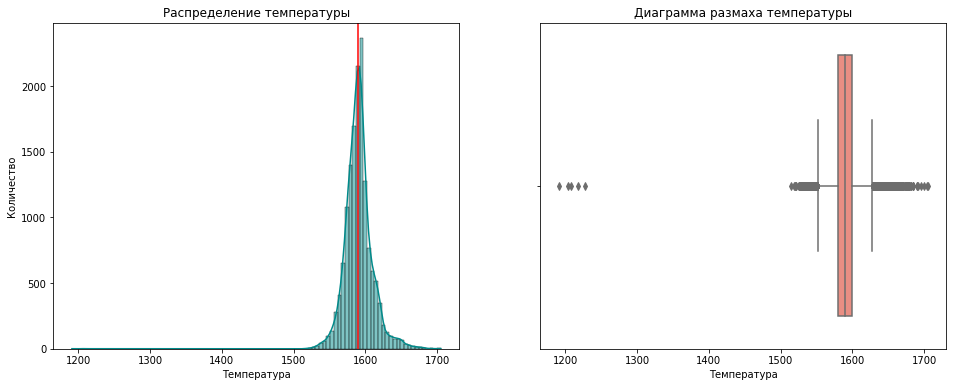

In [64]:
show_graph(
    data_temp_new,
    'temperature',
    'Распределение температуры',
    'Диаграмма размаха температуры',
    'Температура'
)

Распределение температуры напоминает нормальное распределение. Наибольшее количество значений приходится на температуру около 1600 градусов. Имеются явные аномалии в виде температуры, меньше 1250 градусов - удалим их из датафрейма:

In [65]:
data_temp_new = data_temp_new[data_temp_new['temperature'] > 1250]

Проверим получишееся после удаления аномалий распределение:

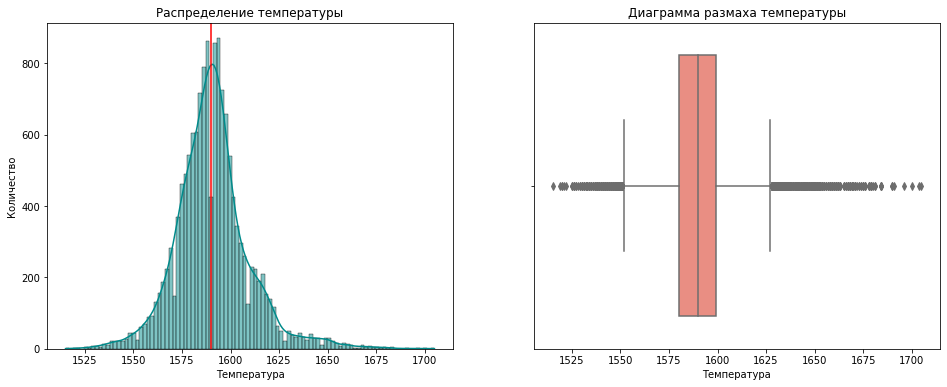

In [66]:
show_graph(
    data_temp_new,
    'temperature',
    'Распределение температуры',
    'Диаграмма размаха температуры',
    'Температура'
)

Распределение температуры также как и до удаления аномалий напоминает нормальное распределение. Остальные выбросы удалять нет смысла, т.к. в зависимости от типа стали и особенностей применяемой технологии температура плавления может достигать различных значений.

Итоговый датафрейм необходимо сформировать с учетом того, что целевым признаком является последняя измеренная температура, т.е. в текущем датафрейме необходимо оставить только те партии, где имеются как минимум два значения температуры (начальная и конечная):

Сформируем итоговый датафрейм `data_temp_new_final`:

In [67]:
data_temp_new_final = data_temp_new.sort_values(by=['key', 'time']).groupby('key').agg(
    temperature = ('temperature', 'last'),
    temperature_measure_number =('key', 'count')
).reset_index()

data_temp_new_final = data_temp_new_final[data_temp_new_final['temperature_measure_number'] > 1]
data_temp_new_final.head()

,key,temperature,temperature_measure_number
0,1,1613.0,6
1,2,1602.0,5
2,3,1599.0,6
3,4,1625.0,5
4,5,1602.0,5


### Датафрейм `data_wire_new`

Произведем переименование столбцов:

In [68]:
data_wire_new.columns = ['key'] + [f'wire_{i}' for i in range(1, 10)]

Выведем общую информацию о датафрейме `data_wire_new`:

In [69]:
get_info(data_wire_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
wire_1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
wire_2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
wire_3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
wire_4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
wire_5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
wire_6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
wire_7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
wire_8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
wire_9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


Типы данных в норме, но датафрейм в каждом столбце имеет пропуски в данных - возможно, этот факт связан с технологическим процессом, когда каждой партии подается определенное количество материала или не подается вовсе. Получается, что пропуски данных означают, что тот или иной проволочный материал 1-9 не использовался в процессе производства той или иной партии. Определим долю пропусков каждого проволочного материала:

In [70]:
pd.DataFrame(
    {
        'Доля пропусков': pd.Series(data_wire_new.drop('key', axis=1).isna().sum() / data_wire_new.shape[0] * 100)
    }
).sort_values(by='Доля пропусков', ascending=False)

,Доля пропусков
wire_5,99.967543
wire_7,99.642973
wire_4,99.545602
wire_8,99.383317
wire_9,99.058747
wire_3,97.955209
wire_6,97.630639
wire_2,64.978903
wire_1,0.843882


Практически все признаки (семь из девяти) имеют более 90% пропусков. Минимальную доля пропущенных значений имеет признак №1.

Отобразим редко использующиеся в производстве проволочные материалы:

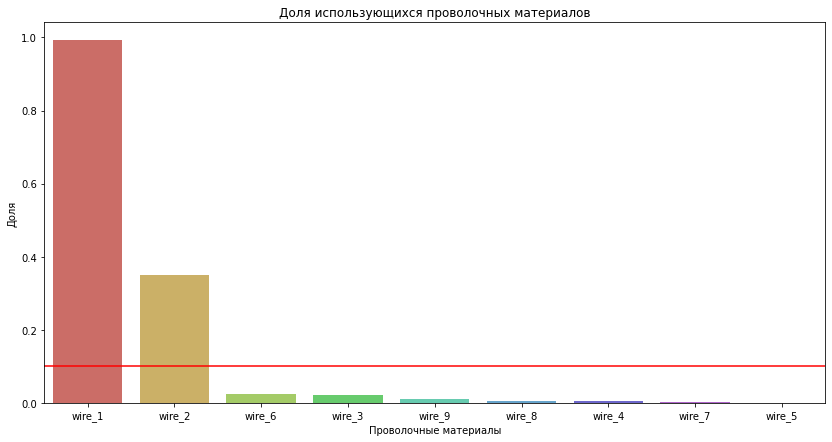

In [71]:
tmp_df = pd.DataFrame(
    {
        'prop': (~data_wire_new.drop('key', axis=1).isna()).mean().sort_values(ascending=False)
    }
)
tmp_df.reset_index(drop=False, inplace=True)
tmp_df.columns = ['wire', 'prop']

show_barplot(
    tmp_df,
    'wire',
    'prop',
    'Доля использующихся проволочных материалов',
    'Проволочные материалы',
    'Доля',
    True,
    0.1
)

Проволочные материалы № 5, 7, 4, 8, 9, 3 и 6 используются при изготовлении менее 10% партий. В дальнейшем возможно не стоит эти данные добавлять в модель.

Далее проверим датафрейм на наличие явных дубликатов:

In [72]:
data_wire_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено. Проверим датафрейм на дубли партий:

In [73]:
data_wire_new['key'].value_counts().max()

1

Максимальное значение сгруппированных партий равно единице, из этого можно сделать вывод о том, что в данном датафрейме партии уникальны в каждой строке.

Проверим, чтобы все партии имели хотя бы один сыпучий материал:

In [74]:
data_wire_new.drop('key', axis=1).sum(axis=1).min()

1.9188

Минимальный объем проволочного материала равен 1.9188, что говорит о том, что каждая партия имеет хотя бы один проволочный материал.

Отобразим гистограмму и "ящик с усами" для всех признаков `wire_1` … `wire_9`:

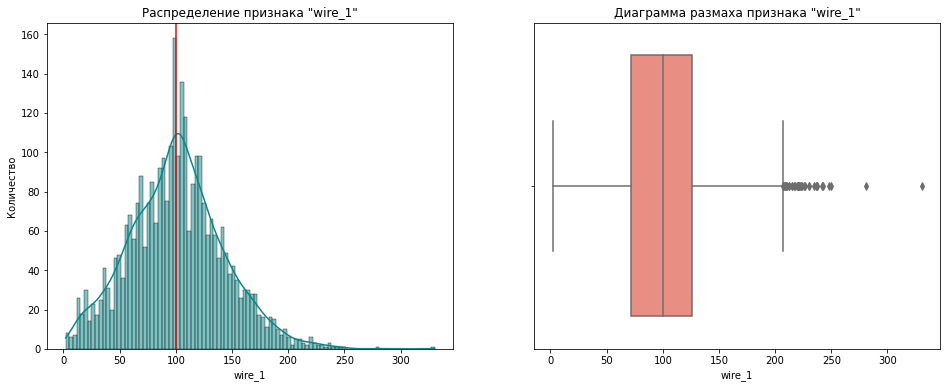

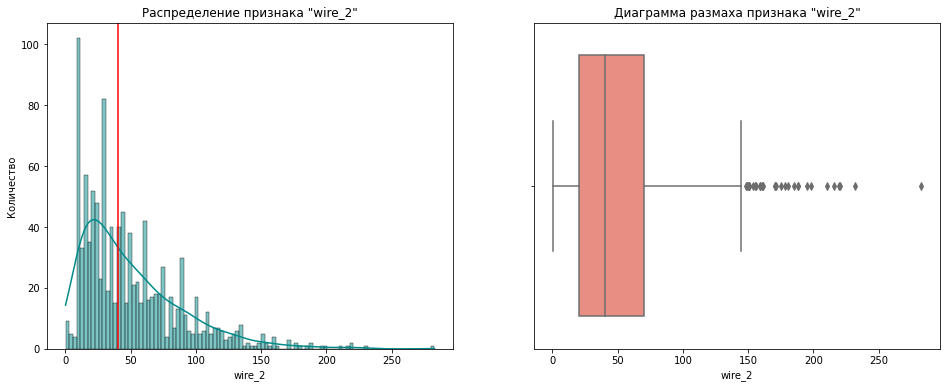

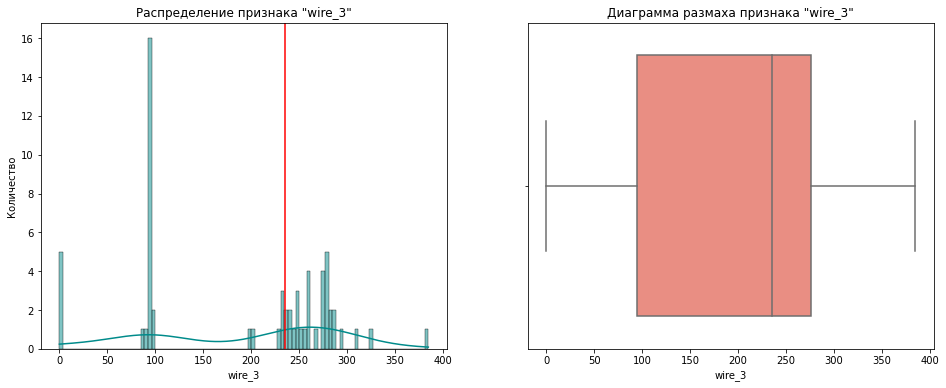

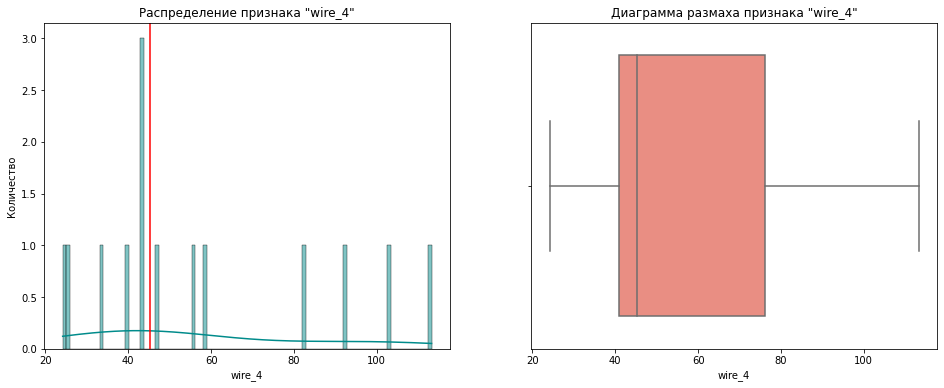

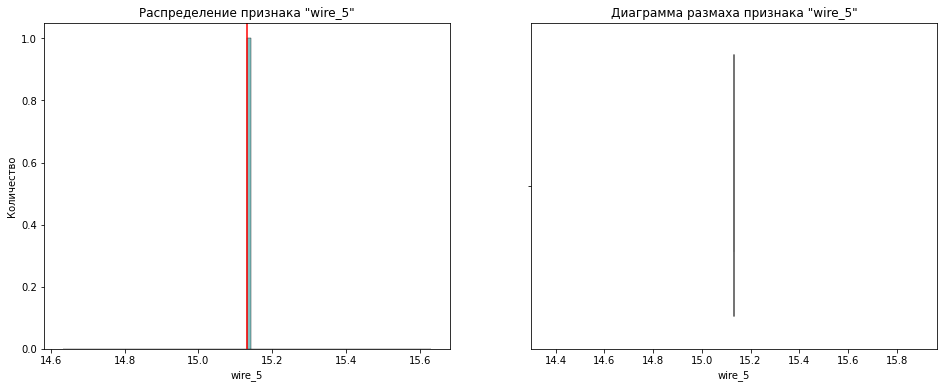

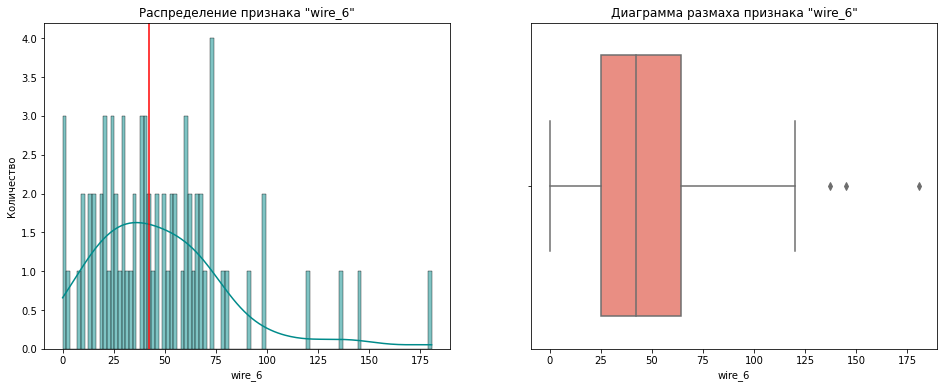

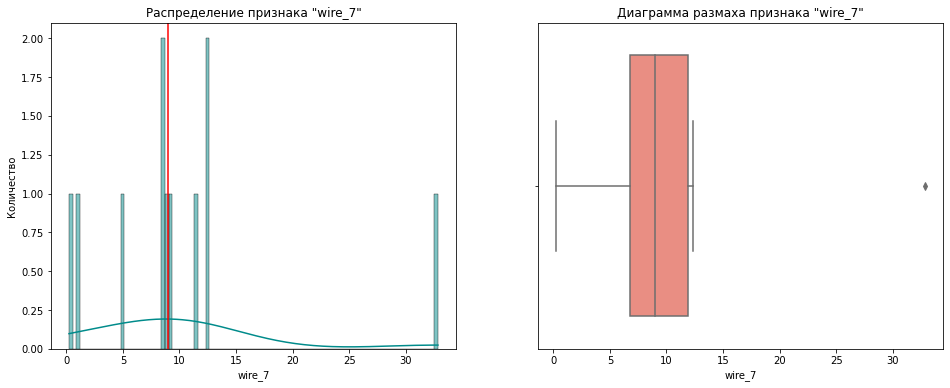

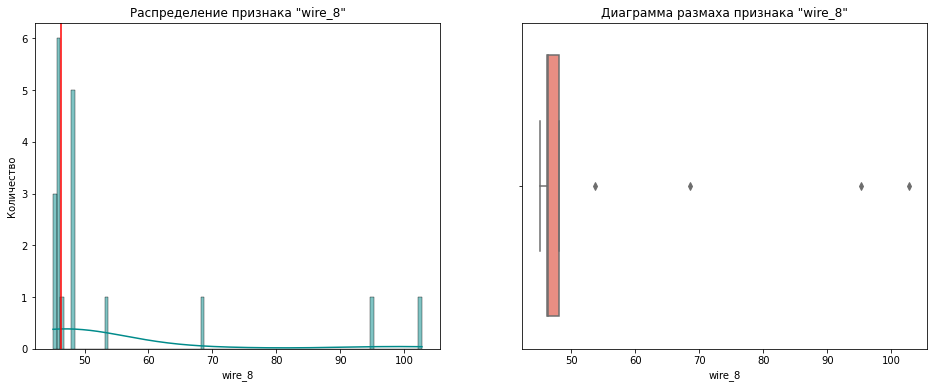

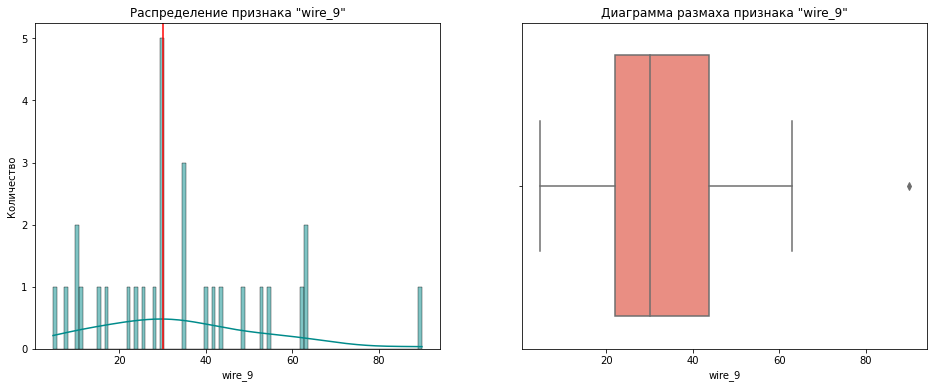

In [75]:
for i in data_wire_new.drop('key', axis=1).columns:
    show_graph(
        data_wire_new,
        i,
        f'Распределение признака "{i}"',
        f'Диаграмма размаха признака "{i}"',
        i
    )

Не все проволочные материалы имеют нормальное распределение - для большинства характерны доминанты определенных значений с характерными пиками на графиках распределения. Графики распределений приближены к нормальному для проволочных материалов № 1 и 2. Обрабатывать выбросы в признаках не будем, т.к. они вполне могут соответствовать максимальным значениям.

Добавим в датафрейм суммарное значение проволочных материалов:

In [76]:
data_wire_new['wire_total'] = data_wire_new.drop('key', axis=1).sum(axis=1)

Сформируем итоговый датафрейм `data_wire_new_final`, заменив пропуски данных на 0 (т.к. отсутствие данных по проволочному материалу означает, что он не подавался):

In [77]:
data_wire_new_final = data_wire_new.fillna(0)

data_wire_new_final.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_total
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


### Датафрейм `data_wire_time_new`

Произведем переименование столбцов:

In [78]:
data_wire_time_new.columns = ['key'] + [f'wire_{i}' for i in range(1, 10)]

Выведем общую информацию о датафрейме `data_wire_time_new`:

In [79]:
get_info(data_wire_time_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


Очевидно, что структуры датафреймов `data_wire_new` и `data_wire_time_new` одинаковы: первый датафрейм отображает данные об объемах, второй - о времени подачи проволочных материалов.

Приведем данные в столбцах `wire_1` … `wire_9` к типу `datetime`:

In [80]:
for i in data_wire_time_new.drop('key', axis=1).columns:
    data_wire_time_new[i] = pd.to_datetime(data_wire_time_new[i])

Проверим типы данных:

In [81]:
data_wire_time_new.dtypes

key                int64
wire_1    datetime64[ns]
wire_2    datetime64[ns]
wire_3    datetime64[ns]
wire_4    datetime64[ns]
wire_5    datetime64[ns]
wire_6    datetime64[ns]
wire_7    datetime64[ns]
wire_8    datetime64[ns]
wire_9    datetime64[ns]
dtype: object

Далее проверим датафрейм на наличие явных дубликатов:

In [82]:
data_wire_time_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено.

На текущий момент видится нецелесообразным включение данных из датафрейма `data_wire_time_new` в модель машиного обучения или даже формирование синтетического признака на его основе, т.к. не прослеживается четкой логической связи этих данных с целевым признаком.

## Объединение данных

Произведем объединение данных из датафреймов в один общий:

In [83]:
data = data_arc_new_final.merge(
    data_bulk_new_final,
    on='key',
    how='left'
).merge(
    data_gas_new,
    on='key',
    how='left'
).merge(
    data_temp_new_final,
    on='key',
    how='left'
).merge(
    data_wire_new_final,
    on='key',
    how='left'
).dropna().drop('key', axis=1)

Выведем первые пять сторок получившегося датафрейма:

In [84]:
data.head()

,min_active_power,max_active_power,mean_active_power,min_reactive_power,max_reactive_power,mean_reactive_power,min_heating_duration,max_heating_duration,mean_heating_duration,heating_iteration,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_total
0,0.305130,0.867133,0.607346,0.211253,0.643691,0.428564,148.0,365.0,219.60,5,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,0.261665,0.786322,0.534852,0.205527,0.542517,0.363339,126.0,338.0,202.75,4,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,0.421693,1.222963,0.812728,0.272562,0.863676,0.587491,65.0,280.0,131.00,5,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,0.310693,0.887855,0.676622,0.241781,0.654661,0.514248,99.0,278.0,185.25,4,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,0.324563,0.892957,0.563238,0.279102,0.660807,0.421998,71.0,415.0,217.25,4,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


Проверим размерность получившегося датафрейма:

In [85]:
data.shape

(2329, 39)

Имеем 2329 строк и 38 столбцов признаков (без учета целевого признака `temperature`).

## Исследовательский анализ и предобработка данных объединенного датафрейма

Выполним исследовательский анализ объединенного датафрейма. Выведем общую информацию о датафрейме `data`:

In [86]:
get_info(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2474
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   min_active_power            2329 non-null   float64
 1   max_active_power            2329 non-null   float64
 2   mean_active_power           2329 non-null   float64
 3   min_reactive_power          2329 non-null   float64
 4   max_reactive_power          2329 non-null   float64
 5   mean_reactive_power         2329 non-null   float64
 6   min_heating_duration        2329 non-null   float64
 7   max_heating_duration        2329 non-null   float64
 8   mean_heating_duration       2329 non-null   float64
 9   heating_iteration           2329 non-null   int64  
 10  bulk_1                      2329 non-null   float64
 11  bulk_2                      2329 non-null   float64
 12  bulk_3                      2329 non-null   float64
 13  bulk_4                      2329 

,count,mean,std,min,25%,50%,75%,max
min_active_power,2329.0,0.420183,0.116559,0.223895,0.333174,0.406886,0.478746,1.140738
max_active_power,2329.0,0.967768,0.232037,0.267676,0.801896,0.972264,1.157592,1.463773
mean_active_power,2329.0,0.664095,0.128350,0.267676,0.576249,0.655642,0.741566,1.243889
min_reactive_power,2329.0,0.304904,0.086622,0.153777,0.240150,0.291964,0.349840,0.875916
max_reactive_power,2329.0,0.721221,0.184939,0.196228,0.588855,0.716088,0.854265,1.270284
mean_reactive_power,2329.0,0.488897,0.097947,0.196228,0.420051,0.484690,0.546490,0.960763
min_heating_duration,2329.0,89.354659,38.346836,11.000000,62.000000,82.000000,117.000000,281.000000
max_heating_duration,2329.0,289.622585,107.166467,57.000000,212.000000,277.000000,339.000000,907.000000
mean_heating_duration,2329.0,172.030434,43.741870,57.000000,141.000000,169.500000,198.750000,378.000000
heating_iteration,2329.0,4.695148,1.606948,1.000000,4.000000,5.000000,6.000000,16.000000


Пропусков в данных нет, типы данных в норме. Далее проверим датафрейм на наличие явных дубликатов:

In [87]:
data.duplicated().sum()

0

Явных дубликатов в объединенном датафрейме не обнаружено. 

Определеним функцию для нахождения категориальных и количественных признаков датафрема:

In [88]:
def get_columns(df):
    return {
        'cat_col_names': df.select_dtypes(exclude='number').columns.tolist(),
        'num_col_names': df.select_dtypes(include='number').columns.tolist()
    }

Определим функцию для отображения тепловой карты корреляционной матрицы:

In [89]:
def get_cm_plot(df, interval_cols, figsize=(20, 15)):
    phik_matrix = df.phik_matrix(interval_cols=interval_cols)
    plot_correlation_matrix(phik_matrix.values,
                        x_labels=phik_matrix.columns,
                        y_labels=phik_matrix.index,
                        vmin=0,
                        vmax=1,
                        color_map='Reds',
                        title=r'Тепловая карта корреляционной матрицы $\phi_K$',
                        fontsize_factor=1.5,
                        figsize=figsize,
                        identity_layout=False
                       )

Проведем корреляционный анализ признаков в количественной шкале в датафрейме для моделирования `data`. Рассчитаем коэффициенты корреляции между всеми количественными признаками и отобразим матрицу корреляций с помощью тепловой карты:

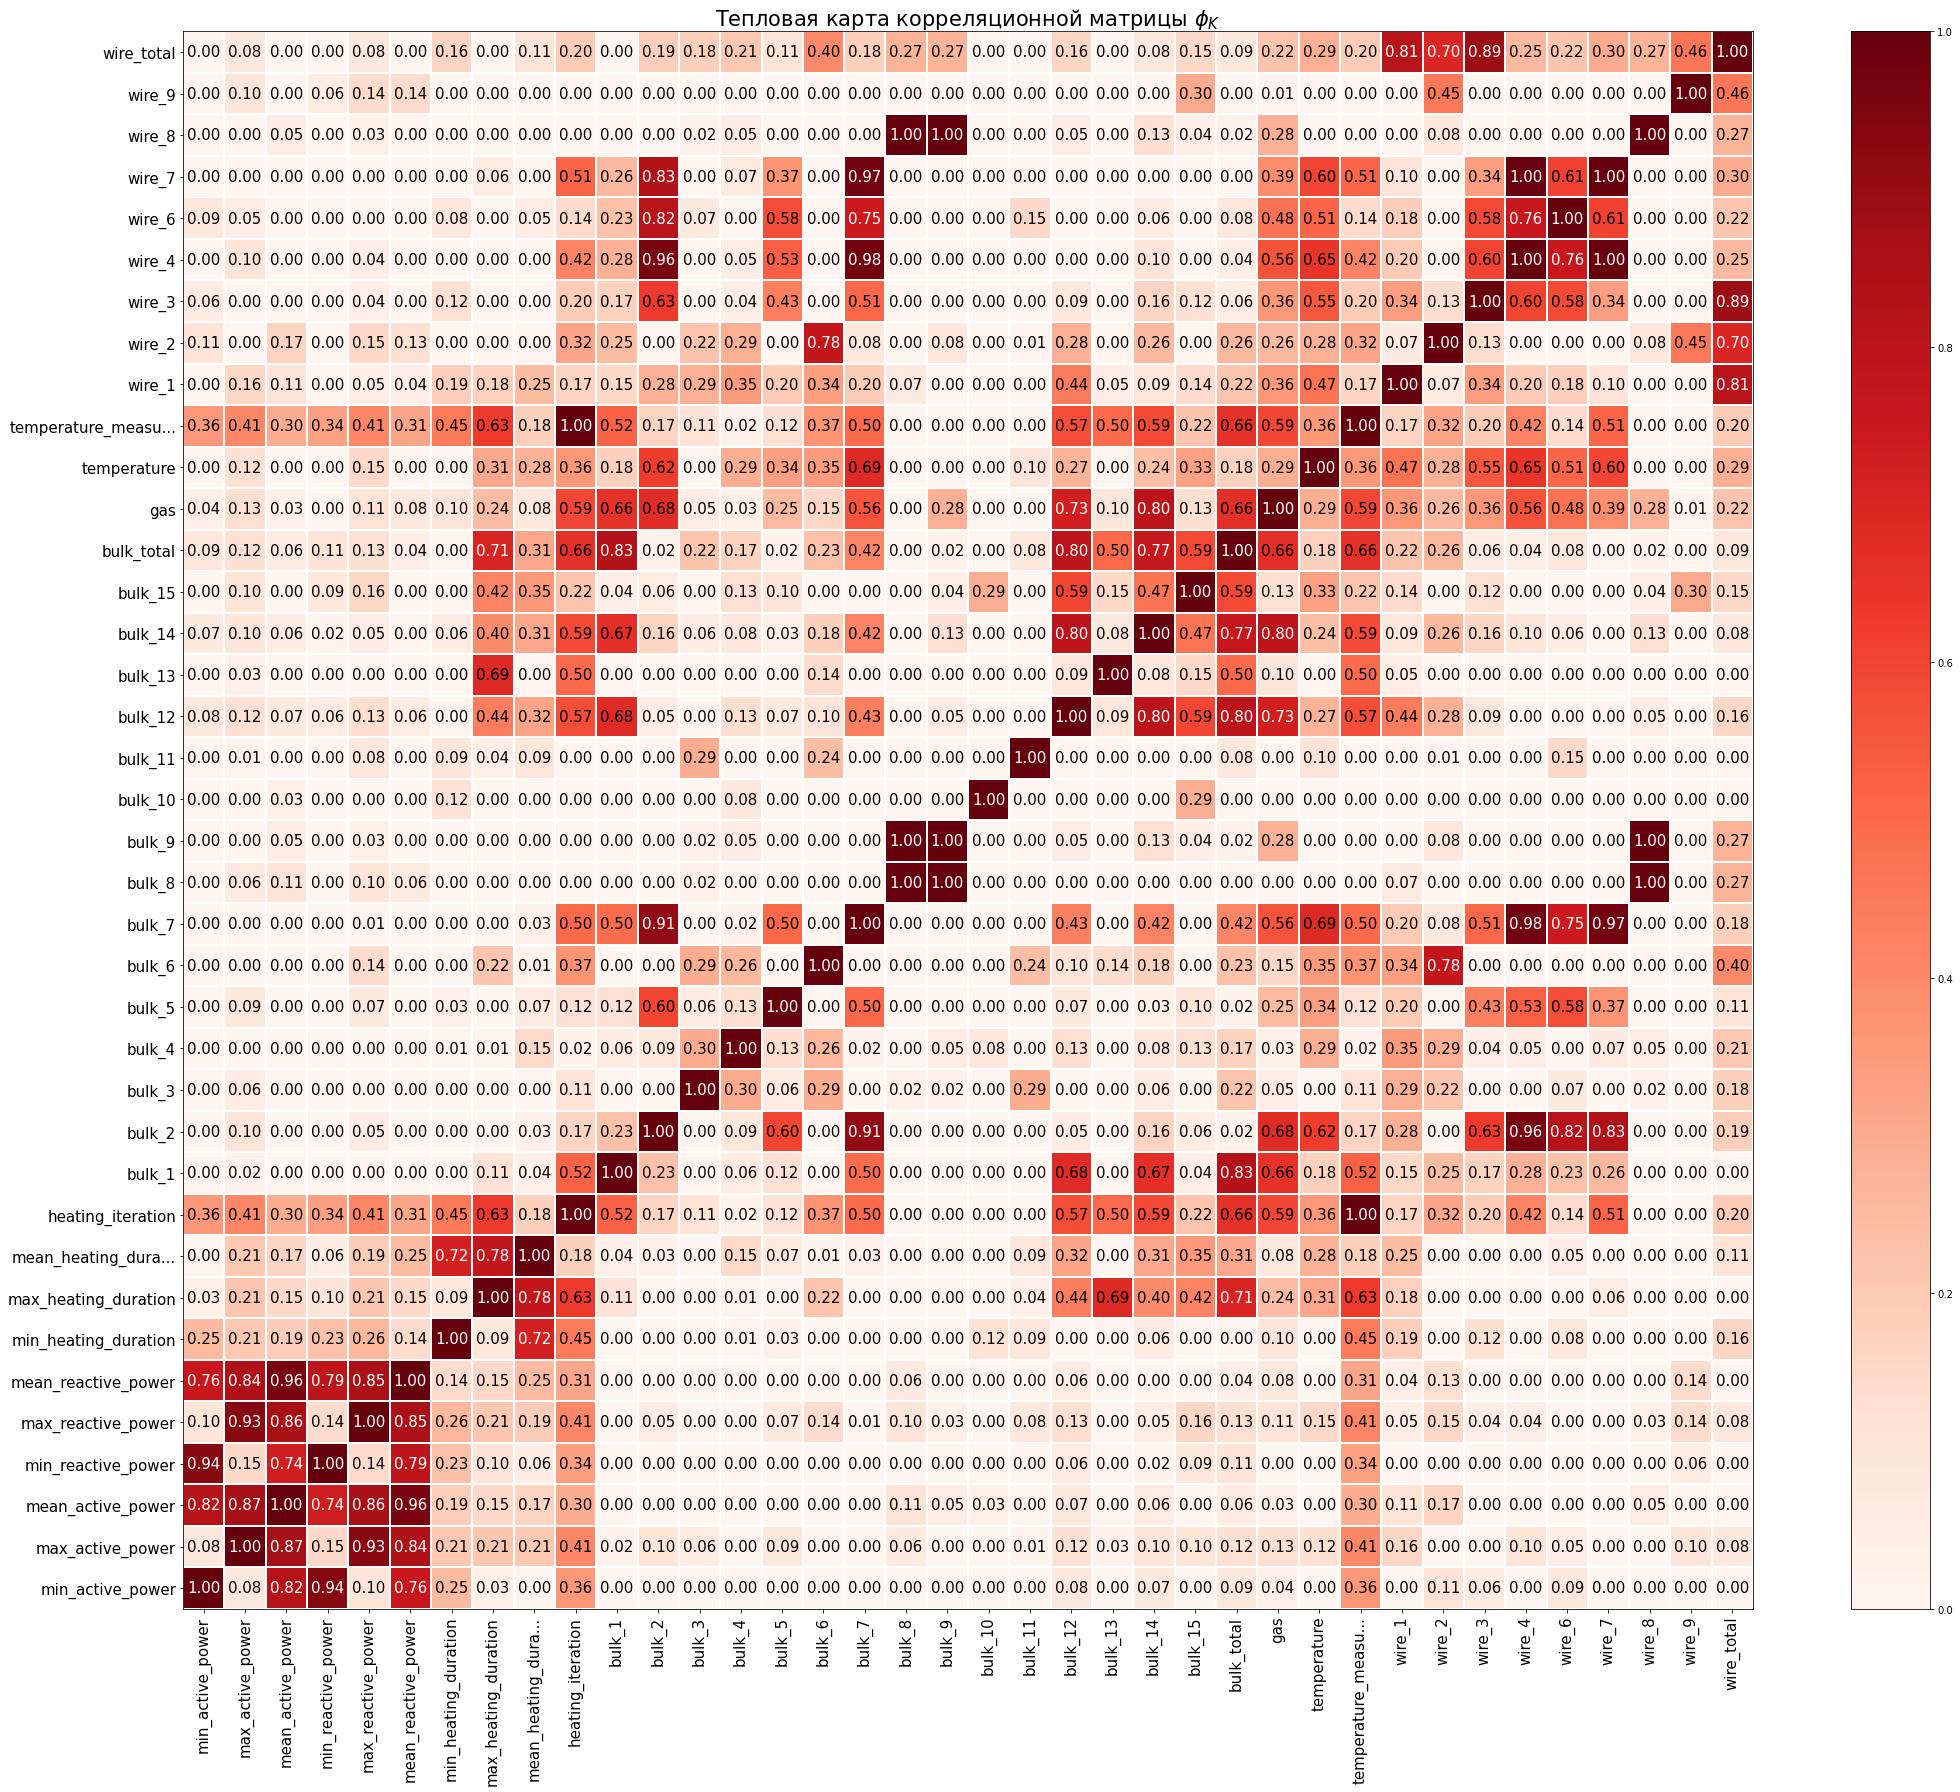

In [90]:
get_cm_plot(data, get_columns(data)['num_col_names'], (30, 25))

Исключим из дафтафрейма признаки, которые имеют слабую корреляцию с таргетом `temperature` (значения коэффициента корреляции меньше 0.15), т.к. такие признаки могут не оказывать значительного влияния на предсказание целевой переменной:

In [91]:
data = data.drop([
    'wire_9',
    'wire_8',
    'bulk_13',
    'bulk_11',
    'bulk_10',
    'bulk_9',
    'bulk_8',
    'bulk_3',
    'min_heating_duration',
    'mean_reactive_power',
    'min_reactive_power',
    'mean_active_power',
    'max_active_power',
    'min_active_power'
], axis=1)

Проверим признаки на мультиколлинеарность, для этого снова построим тепловую карту корреляционной матрицы:

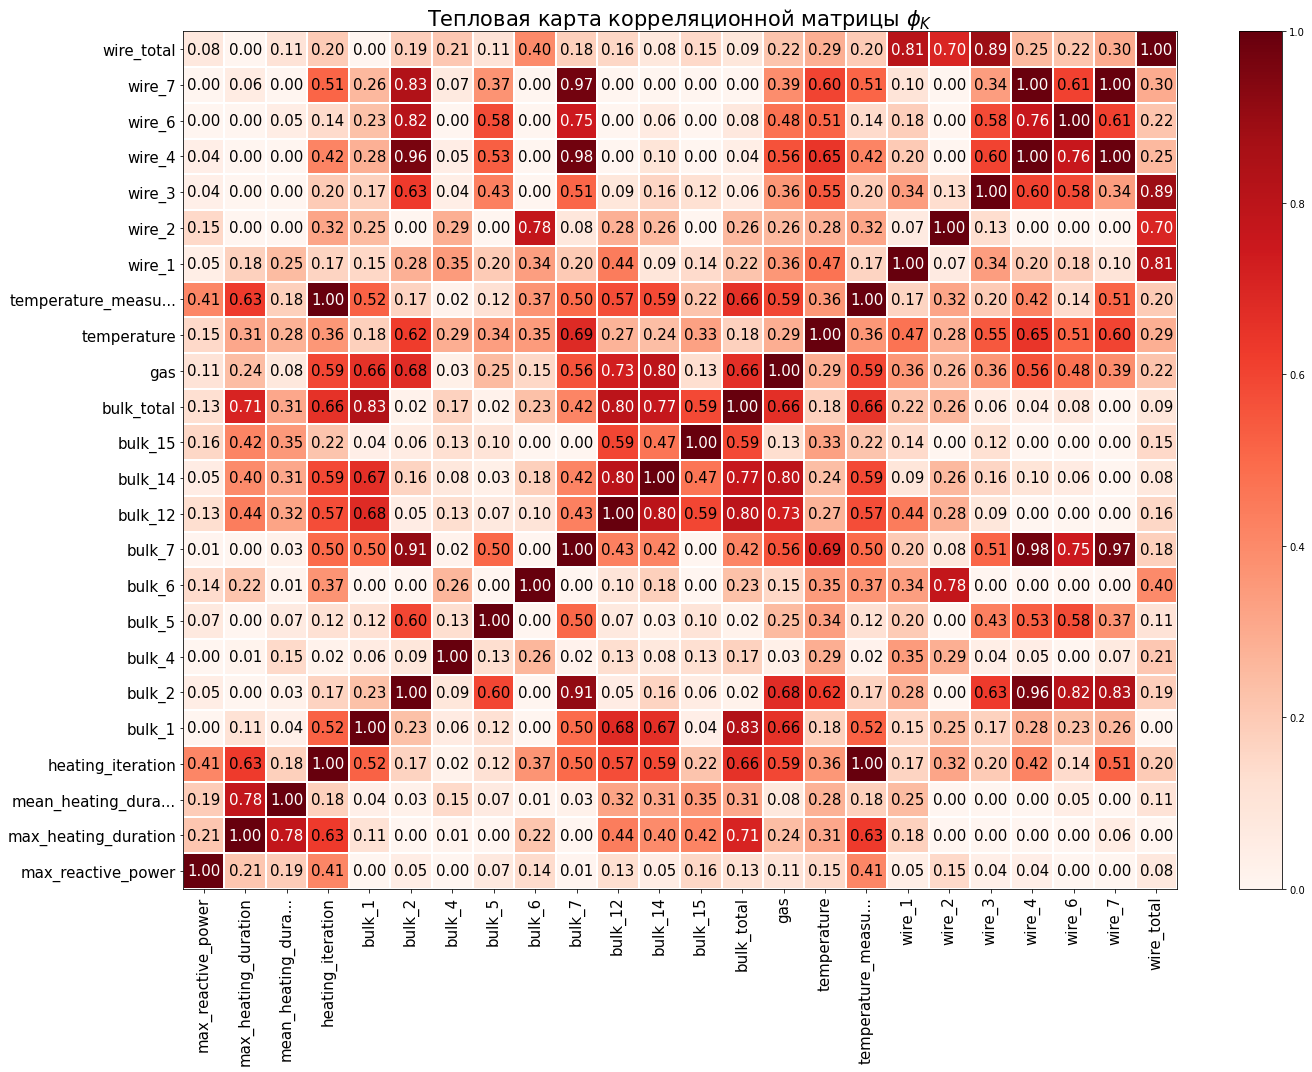

In [92]:
get_cm_plot(data, get_columns(data)['num_col_names'])

Найдем признаки, которые имеют между собой высокую корреляцию (значения коэффициента корреляции больше 0.9), и исключим из датафрейма те из них, которые имеют более низкую корреляцию с таргетом `temperature`, т.к. такие признаки могут привести к избыточности и мультиколлинеарности:

In [93]:
data = data.drop([
    'wire_7',
    'wire_4',
    'bulk_2',
    'temperature_measure_number'
], axis=1)

Снова построим тепловую карту корреляционной матрицы:

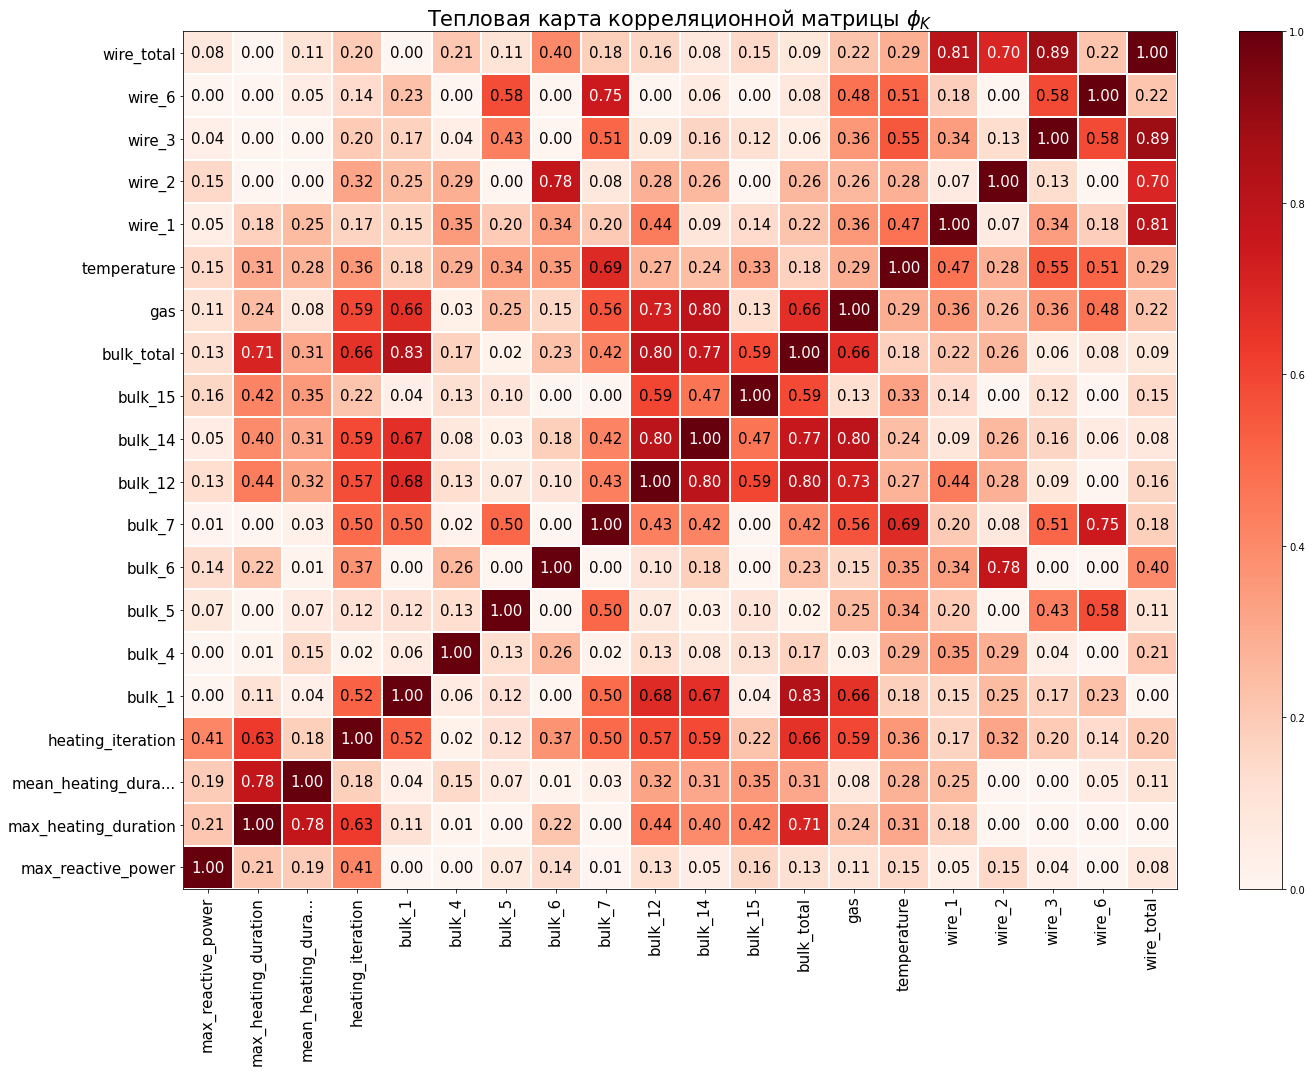

In [94]:
get_cm_plot(data, get_columns(data)['num_col_names'])

Теперь отсутствуют признаки, не связанные с целевым, и устранена мультиколлинеарность между признаками - данные можно использовать в модели.

Отобразим гистограмму и "ящик с усами" для всех признаком объединенного датафрейма `data`:

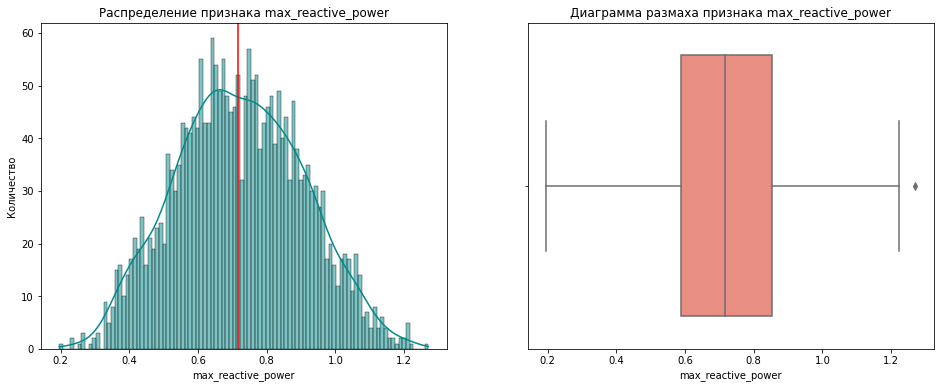

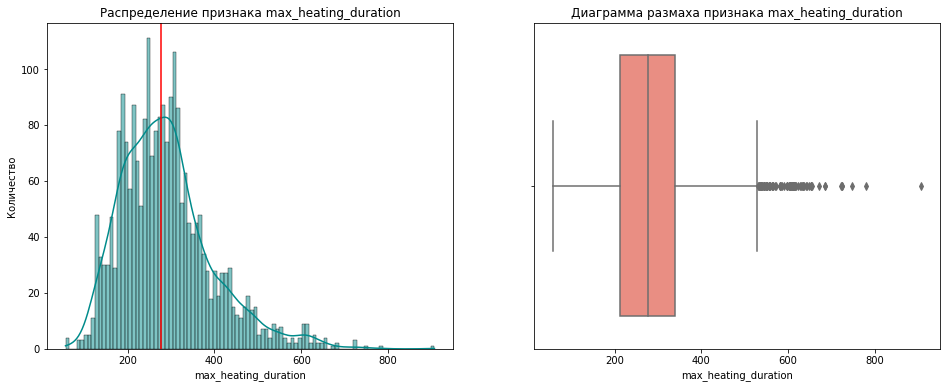

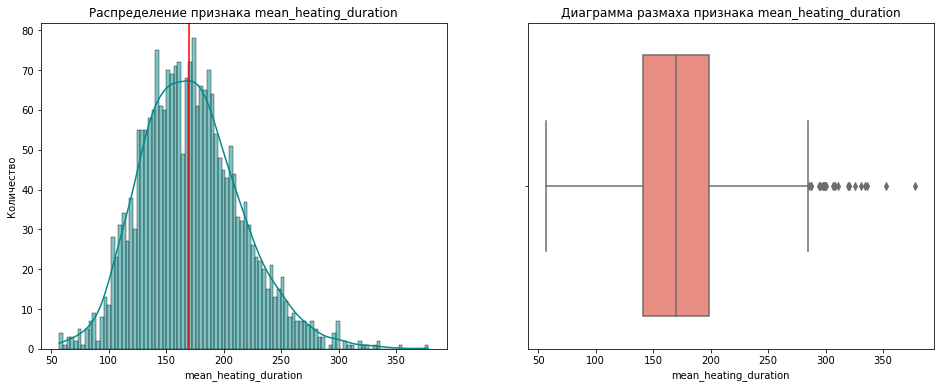

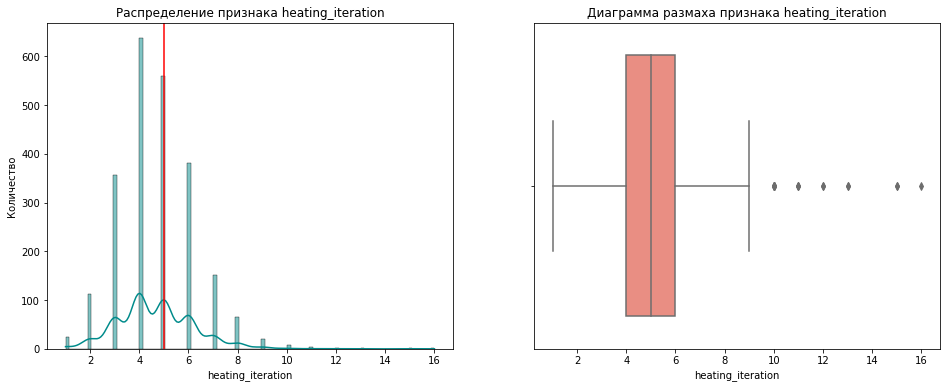

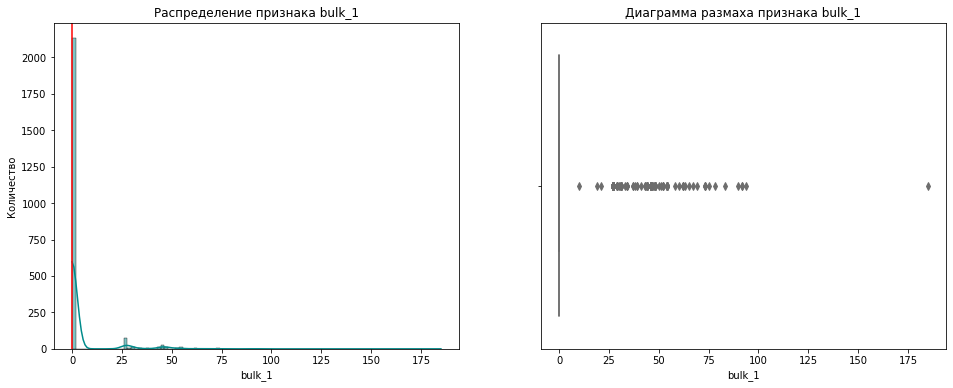

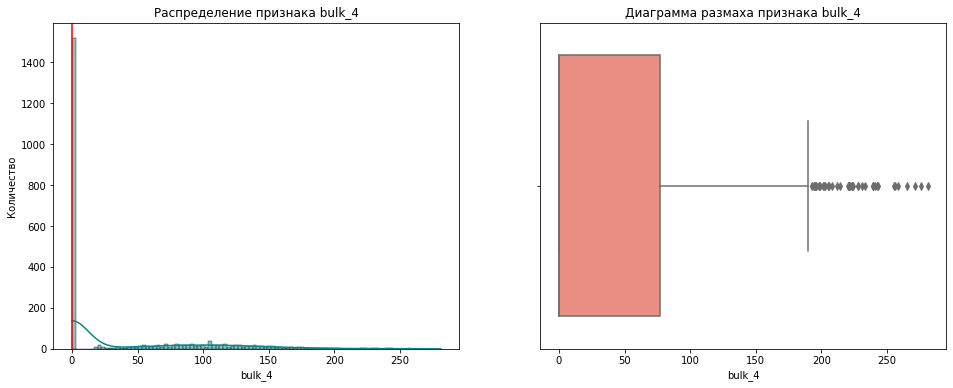

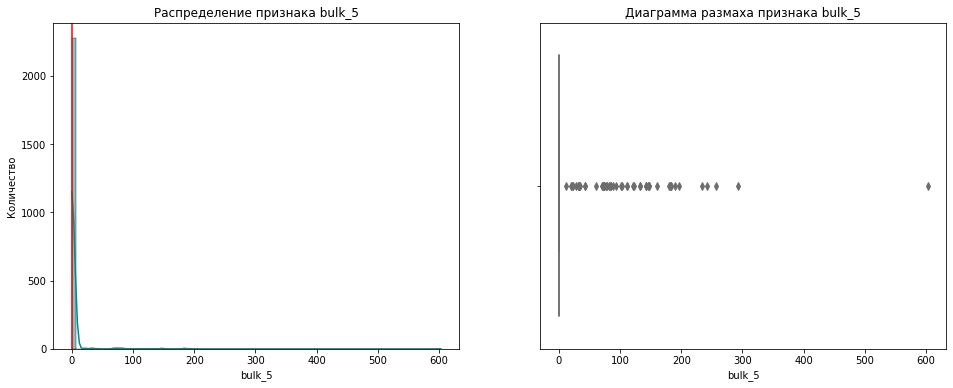

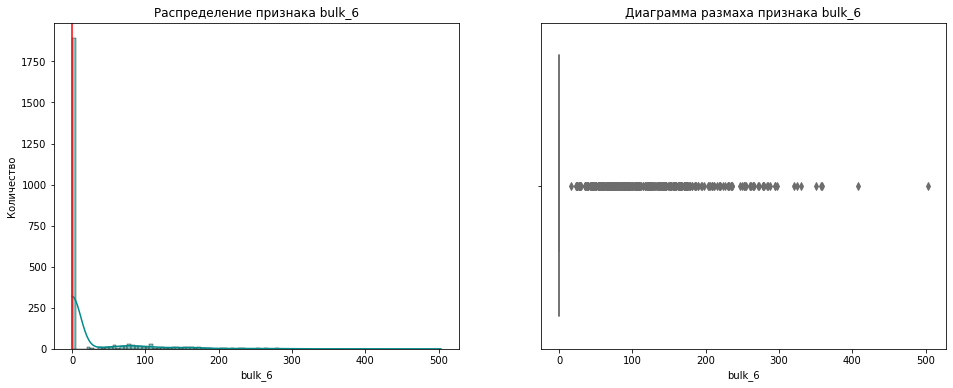

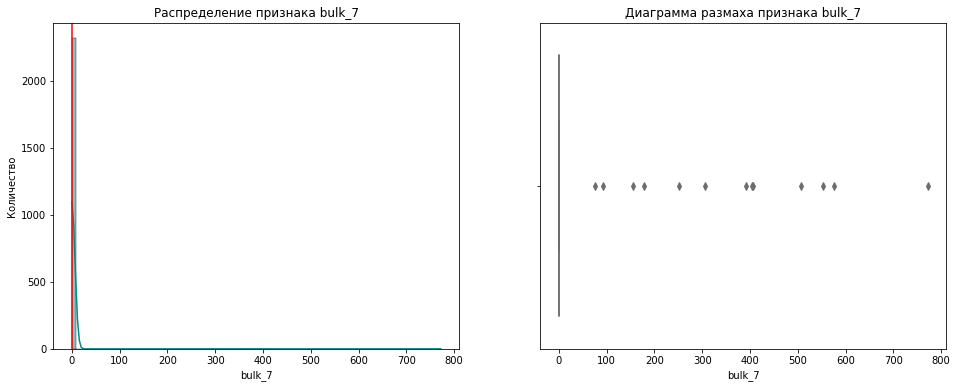

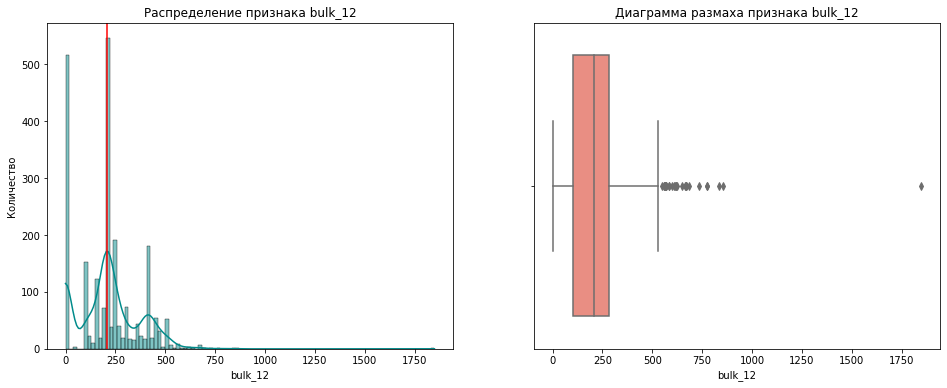

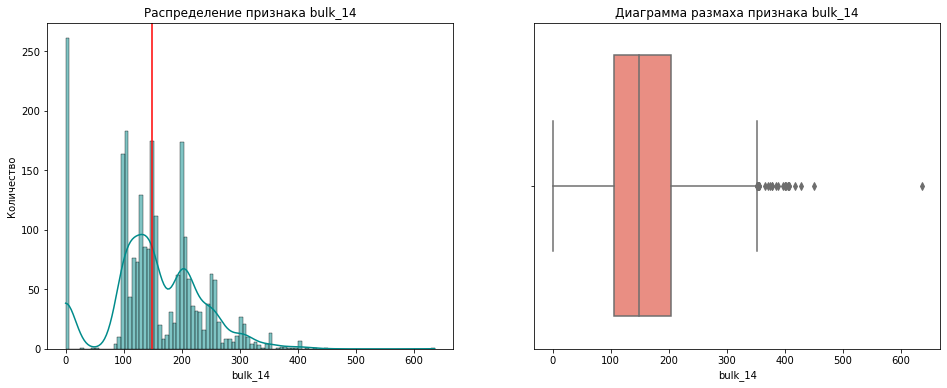

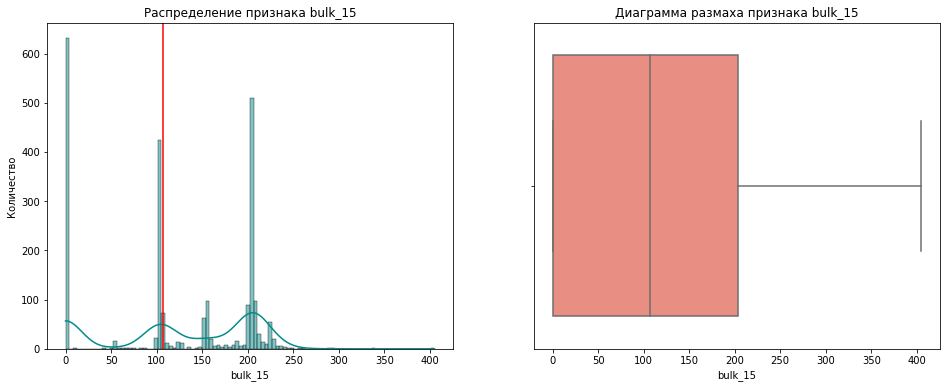

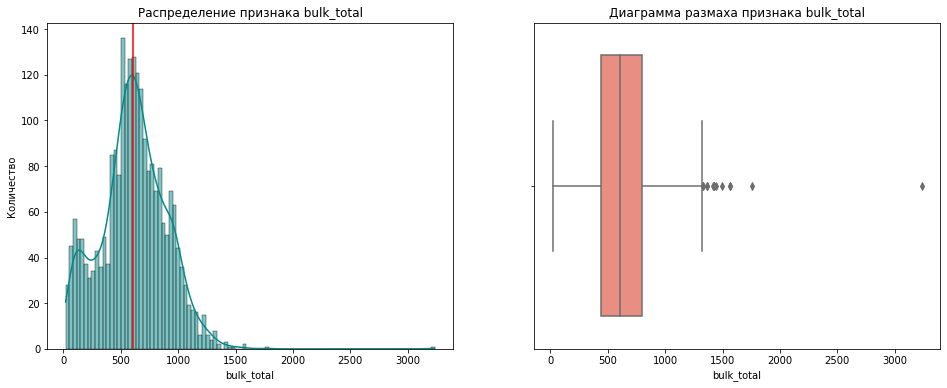

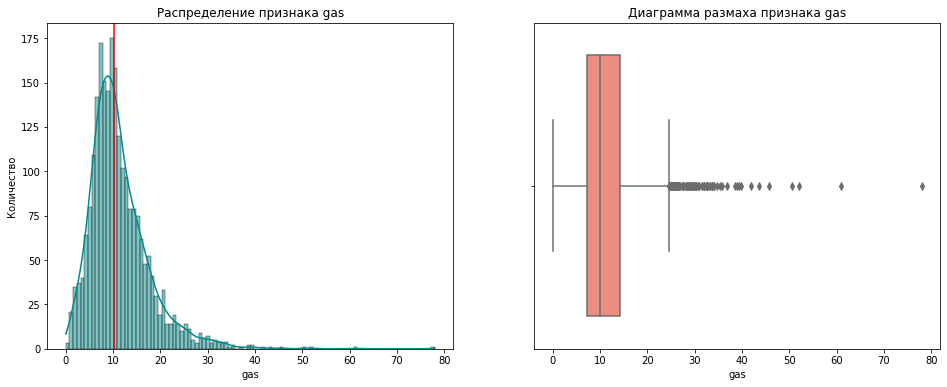

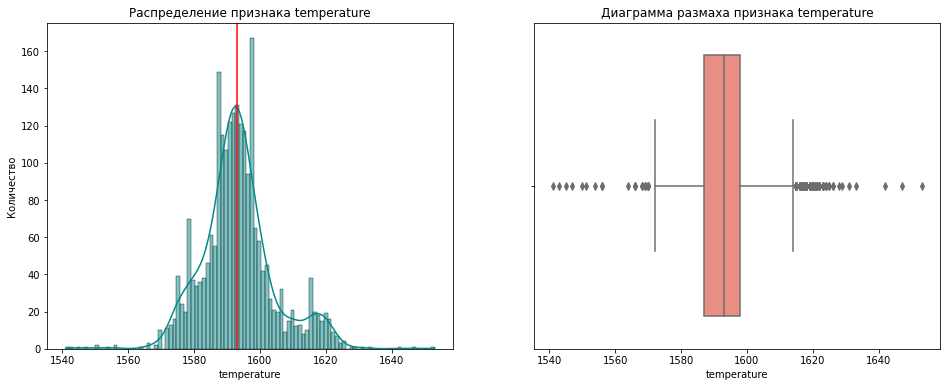

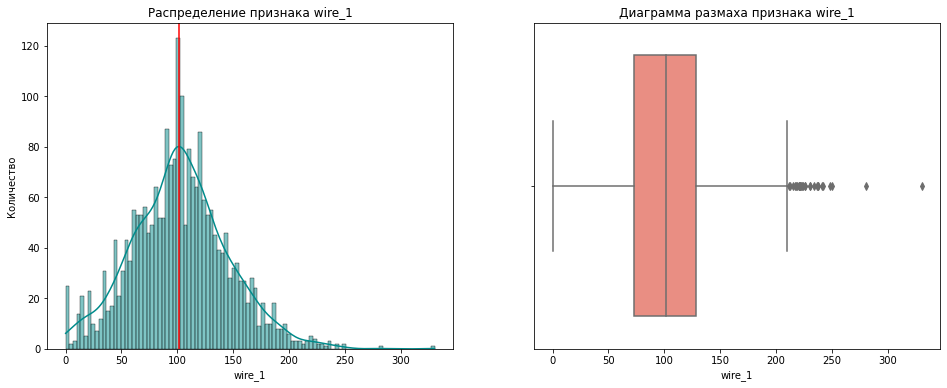

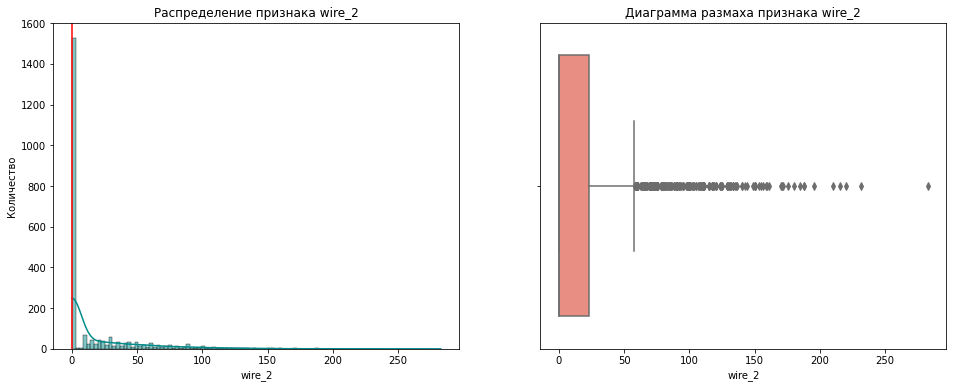

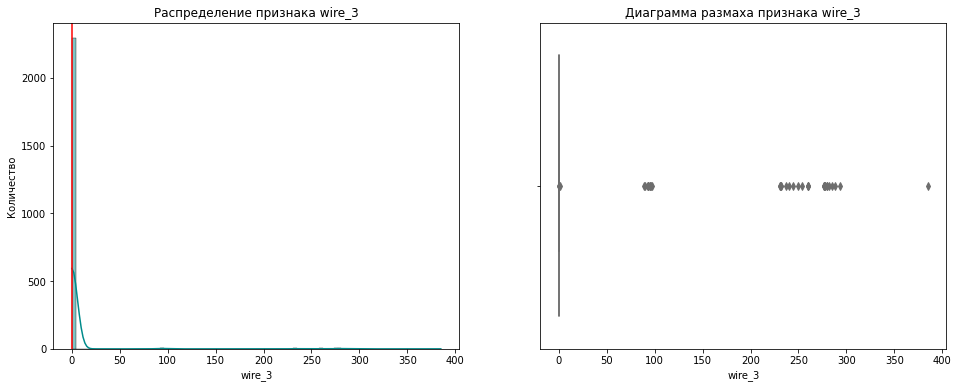

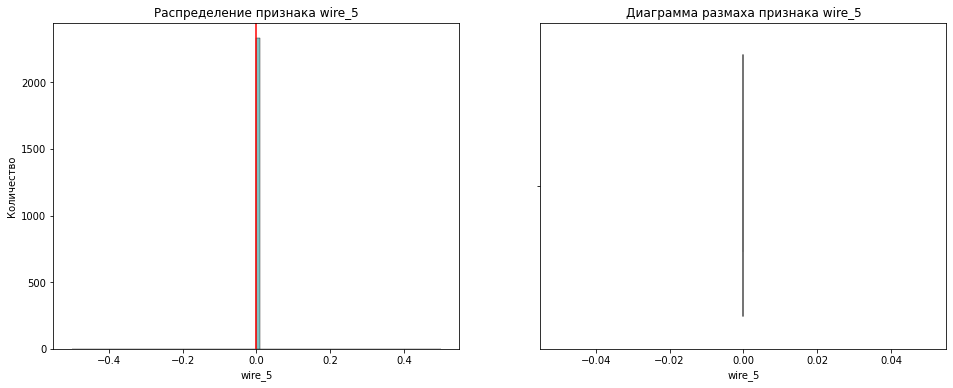

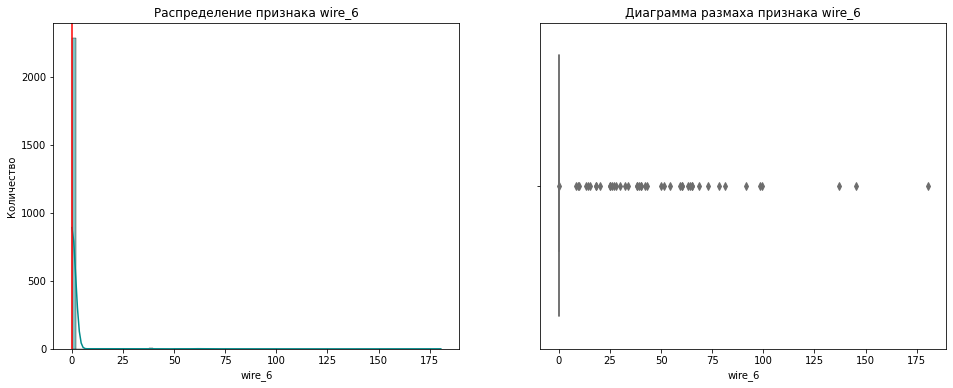

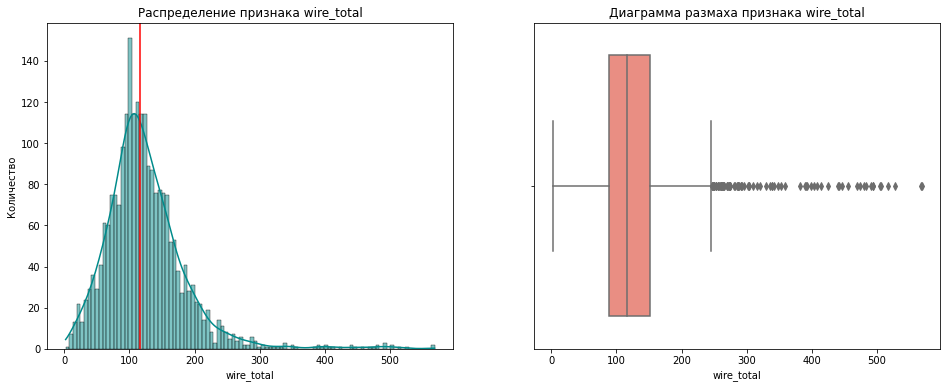

In [95]:
for i in data.columns:
    show_graph(
        data,
        i,
        f'Распределение признака {i}',
        f'Диаграмма размаха признака {i}',
        i
    )

Большинство признаков имеют распределение, похожее на нормальное, кроме признаков `bulk` и `wire`, где пропуски были заменены нулями, из-за чего график распределения потерял форму, приближенную к нормальному распределению. Практически все признаки если и имеют выбросы, то в стороне максимальных значений. Их удаление, возможно, повлияет на уменьшение ошибки моделей, но при этом высока вероятность, что обученная лучшая модель не будет соответствовать реальным условиям технологического процесса.

## Подготовка данных для обучения моделей

Сформируем тренировочные и тестовые выборки:

In [96]:
X = data.drop('temperature', axis=1)
y = data['temperature']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (1746, 20)
X_test: (583, 20)
y_train: (1746,)
y_test: (583,)


Данные подготовлены для обучения моделей.

## Обучение моделей машинного обучения

Используя пайплайны, применим следующие модели:
* Модель LinearRegression (линейная регрессия)
* Модель LightGBMRegressor (деревья принятия решений с градиентным бустингом)
* Модель CatBoostRegressor (градиентный бустинг)
* Модель PassiveAggressiveRegressor (пассивно-агрессивный алгоритм)

Создадим пайплайн для подготовки количественных признаков:

In [97]:
num_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('minmax', MinMaxScaler())
])

Создадим общий пайплайн для обработки данных:

In [98]:
data_preprocessor = ColumnTransformer(
    [('num', num_pipe, X.columns)], 
    remainder='passthrough'
)

### Модель LinearRegression

Создадим итоговый пайплайн - подготовка данных и модель:

In [99]:
pipe_final_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

Создадим словарь со значениями гиперпараметров:

In [100]:
param_grid_lr = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Для поиска лучшей модели будем использовать GridSearchCV:

In [101]:
%%time

gs_lr = GridSearchCV(
    pipe_final_lr, 
    param_grid_lr, 
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

gs_lr.fit(X_train, y_train)
lr_train_mae = -gs_lr.best_score_
lr_train_time = gs_lr.cv_results_['mean_fit_time'].mean()

print(f'Лучшая модель и ее параметры:\n\n {gs_lr.best_estimator_}')
print(f'Метрика MAE лучшей модели на кросс-валидации: {lr_train_mae}')
print(f'Среднее время обучения: {lr_train_time} сек.')

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['max_reactive_power', 'max_heating_duration', 'mean_heating_duration',
       'heating_iteration', 'bulk_1', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_12', 'bulk_14', 'bulk_15', 'bulk_total', 'gas', 'wire_1',
       'wire_2', 'wire_3', 'wire_5', 'wire_6', 'wire_total'],
      dtype='object'))])),
                ('models', LinearRegression())])
Метрика MAE лучшей модели на кросс-валидации: 7.489003596543088
Среднее время обучения: 0.058190313975016277 сек.
CPU times: user 721 ms, sys: 605 ms, total: 1.33 s
Wall time: 1.27 s


### Модель LGBMRegressor

Создадим итоговый пайплайн - подготовка данных и модель:

In [102]:
pipe_final_lgbmr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1))
])

Создадим словарь со значениями гиперпараметров:

In [103]:
param_grid_lgbmr = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1)],
        'models__n_estimators': range(50, 100, 10),
        'models__max_depth': range(3, 8),
        'models__num_leaves': range(2, 10),
        'models__learning_rate': [0.05, 0.06, 0.07],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Для поиска лучшей модели будем использовать GridSearchCV:

In [104]:
%%time

gs_lgbmr = GridSearchCV(
    pipe_final_lgbmr, 
    param_grid_lgbmr, 
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

gs_lgbmr.fit(X_train, y_train)
lgbmr_train_mae = -gs_lgbmr.best_score_
lgbmr_train_time = gs_lgbmr.cv_results_['mean_fit_time'].mean()

print(f'Лучшая модель и ее параметры:\n\n {gs_lgbmr.best_estimator_}')
print(f'Метрика MAE лучшей модели на кросс-валидации: {lgbmr_train_mae}')
print(f'Среднее время обучения {lgbmr_train_time} сек.')

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['max_reactive_power', 'max_heating_duration', 'mean_heating_duration',
       'heating_iteration', 'bulk_1', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_12', 'bulk_14', 'bulk_15', 'bulk_total', 'gas', 'wire_1',
       'wire_2', 'wire_3', 'wire_5', 'wire_6', 'wire_total'],
      dtype='object'))])),
                ('models',
                 LGBMRegressor(learning_rate=0.07, max_depth=7, n_estimators=70,
                               num_leaves=8, random_state=190525,
                               verbosity=-1))])
Метрика MAE лучшей модели на кросс-валидации: 7.191734647671986
Среднее время обучения 0.5753007643487719 сек.
CPU times: user 1h 30min 54s, sys: 49 s, total: 1h 31min 43s
Wall time: 1h 32min 39s


### Модель CatBoostRegressor

Создадим итоговый пайплайн - подготовка данных и модель:

In [105]:
pipe_final_cbr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))
])

Создадим словарь со значениями гиперпараметров:

In [106]:
param_grid_cbr = [
    {
        'models': [CatBoostRegressor(verbose=False)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Для поиска лучшей модели будем использовать GridSearchCV:

In [107]:
%%time

gs_cbr = GridSearchCV(
    pipe_final_cbr, 
    param_grid_cbr, 
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

gs_cbr.fit(X_train, y_train)
cbr_train_mae = -gs_cbr.best_score_
cbr_train_time = gs_cbr.cv_results_['mean_fit_time'].mean()

print(f'Лучшая модель и ее параметры:\n\n {gs_cbr.best_estimator_}')
print(f'Метрика RMSE лучшей модели на кросс-валидации: {cbr_train_mae}')
print(f'Среднее время обучения {cbr_train_time} сек.')

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['max_reactive_power', 'max_heating_duration', 'mean_heating_duration',
       'heating_iteration', 'bulk_1', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_12', 'bulk_14', 'bulk_15', 'bulk_total', 'gas', 'wire_1',
       'wire_2', 'wire_3', 'wire_5', 'wire_6', 'wire_total'],
      dtype='object'))])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x7fbb02a56ca0>)])
Метрика RMSE лучшей модели на кросс-валидации: 7.320373625987116
Среднее время обучения 4.386614513397217 сек.
CPU times: user 50.7 s, sys: 2.1 s, total: 52.8 s
Wall time: 1min 10s


### Модель PassiveAggressiveRegressor

Создадим итоговый пайплайн - подготовка данных и модель:

In [108]:
pipe_final_par = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', PassiveAggressiveRegressor(random_state=RANDOM_STATE))
])

Создадим словарь со значениями гиперпараметров:

In [109]:
param_grid_par = [
    {
        'models': [PassiveAggressiveRegressor(max_iter=100, random_state=RANDOM_STATE)],
        'models__C': [0.1, 0.2, 0.3, 0.5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Для поиска лучшей модели будем использовать GridSearchCV:

In [110]:
%%time

gs_par = GridSearchCV(
    pipe_final_par, 
    param_grid_par, 
    cv=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

gs_par.fit(X_train, y_train)
par_train_mae = -gs_par.best_score_
par_train_time = gs_par.cv_results_['mean_fit_time'].mean()

print(f'Лучшая модель и ее параметры:\n\n {gs_par.best_estimator_}')
print(f'Метрика RMSE лучшей модели на кросс-валидации: {par_train_mae}')
print(f'Среднее время обучения {par_train_time} сек.')

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['max_reactive_power', 'max_heating_duration', 'mean_heating_duration',
       'heating_iteration', 'bulk_1', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_12', 'bulk_14', 'bulk_15', 'bulk_total', 'gas', 'wire_1',
       'wire_2', 'wire_3', 'wire_5', 'wire_6', 'wire_total'],
      dtype='object'))])),
                ('models',
                 PassiveAggressiveRegressor(C=0.2, max_iter=100,
                                            random_state=190525))])
Метрика RMSE лучшей модели на кросс-валидации: 7.454247135140885
Среднее время обучения 0.010016671419143678 сек.
CPU times: user 8.32 s, sys: 41 ms, total: 8.36 s
Wall time: 8.37 s


## Анализ моделей

Сведем все полученные показатели по моделям в одной таблице:

In [111]:
compare_table = pd.DataFrame({
    'Модель': [
        'LinearRegression',
        'LGBMRegressor',
        'CatBoostRegressor',
        'PassiveAggressiveRegressor'
    ],
    'Метрика MAE на кросс-валидации': [lr_train_mae, lgbmr_train_mae, cbr_train_mae, par_train_mae],
    'Среднее время обучения': [lr_train_time, lgbmr_train_time, cbr_train_time, par_train_time]
})
compare_table

,Модель,Метрика MAE на кросс-валидации,Среднее время обучения
0,LinearRegression,7.489004,0.058190
1,LGBMRegressor,7.191735,0.575301
2,CatBoostRegressor,7.320374,4.386615
3,PassiveAggressiveRegressor,7.454247,0.010017


На основе полученных на кросс-валидации метрик можно сделать вывод, что все текущие модели показали примерно равные результаты. В итоге все же предпочтение стоит отдать модели LGBMRegressor, т.к. значение метрики *MAE* у нее самое низкое по сравнению с остальными моделями.

Посчитаем метрику *MAE* лучшей модели на тестовой выборке:

In [112]:
print(f'Метрика MAE модели LGBMRegressor на тестовой выборке: {mean_absolute_error(y_test, gs_lgbmr.best_estimator_.predict(X_test))}')

Метрика MAE модели LGBMRegressor на тестовой выборке: 6.785634045881671


Метрика *MAE* на тестовой выборке находится в рамках указанного заказчиком допустимого значения - меньше 6.8.

Важно также проверить лучшую модель на адекватность, сравнив качество ее предсказаний с качеством модели, которая предсказывала бы константу (чтобы вдруг не оказалось, что не было бы большого смысла заниматься созданием новых признаков, тюнингом и кросс-валидацией моделей, если можно было бы просто предсказывать среднее значение тренировочной выборки). В качестве константной модели будем использовать DummyRegressor - эта модель как раз создана для генерирования константных предсказаний.

Создадим словарь со значениями гиперпараметров для модели DummyRegressor:

In [113]:
param_grid_dummy = [
    {
        'models': [DummyRegressor()],
        'models__strategy': ['mean', 'median', 'quantile', 'constant'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [114]:
rs_dummy = GridSearchCV(
    pipe_final_lr, 
    param_grid_dummy, 
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
rs_dummy.fit(X_train, y_train)

print(f'Лучшая модель и ее параметры:\n\n {rs_dummy.best_estimator_}')
print(f'Метрика MAE лучшей модели на тестовой выборке: {mean_absolute_error(y_test, rs_dummy.best_estimator_.predict(X_test))}')

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['max_reactive_power', 'max_heating_duration', 'mean_heating_duration',
       'heating_iteration', 'bulk_1', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_12', 'bulk_14', 'bulk_15', 'bulk_total', 'gas', 'wire_1',
       'wire_2', 'wire_3', 'wire_5', 'wire_6', 'wire_total'],
      dtype='object'))])),
                ('models', DummyRegressor(strategy='median'))])
Метрика MAE лучшей модели на тестовой выборке: 7.305317324185249


Результат тестирования нашей модели на тестовой выборке оказался лучше, чем результат константной модели - значит, наша модель не является бесполезной.

Проанализируем значимость признаков лучшей модели. Извлечем значимости признаков:

In [115]:
best_model = gs_lgbmr.best_estimator_
lgbm_regressor = best_model.named_steps['models']
importances = lgbm_regressor.feature_importances_
importances_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

Выведем важные признаки с сортировкой от наибольшего к наименьшему вкладу:

In [116]:
importances_df.sort_values(by='importance', ascending=False, inplace=True)
importances_df

,feature,importance
14,wire_1,67
2,mean_heating_duration,61
3,heating_iteration,51
13,gas,35
15,wire_2,33
1,max_heating_duration,32
7,bulk_6,32
11,bulk_15,29
10,bulk_14,28
0,max_reactive_power,27


Визуализируем результаты:

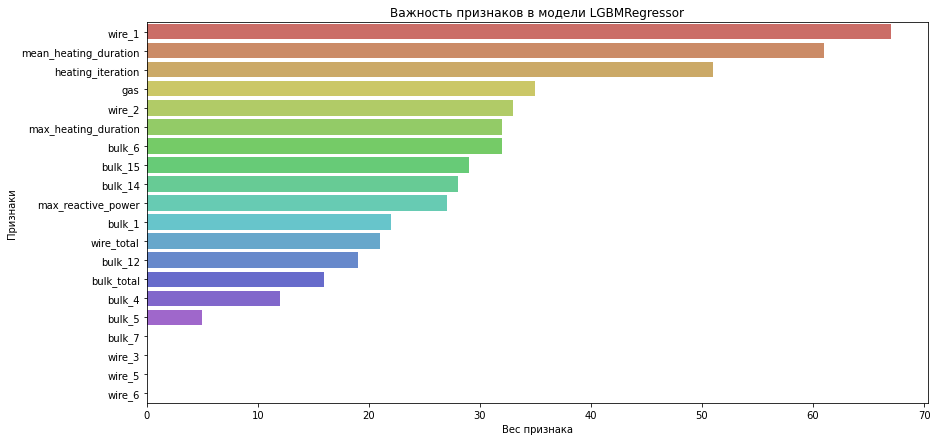

In [117]:
show_barplot(
    importances_df,
    'importance',
    'feature',
    'Важность признаков в модели LGBMRegressor',
    'Вес признака',
    'Признаки',
    False
)

Наиболее важными признаками для модели LGBMRegressor являются:
* `wire_1` - объем подаваемого проволочного материала №1
* `heating_iteration` - количество итераций нагрева 
* `mean_heating_duration` - средняя продолжительность нагрева

## Итоговые выводы

В рамках исследования было необходимо проанализировать набор данных о технологическом процессе обработки стали, предоставленный металлургическим комбинатом «Стальная птица». Цель бизнеса - оптимизация производственных расходов путем уменьшения потребления электроэнергии на этапе обработки стали.

В рамках исследования было необходимо решить следующие задачи:
* Построить несколько моделей машинного обучения для предсказания температуры сплава.
* На основе заданного заказчиком порогового значения метрики *MAE* на тестовой выборке (не больше 6.8) выбрать подходящую модель.

В ходе исследования при решении данных задач были реализованы следующие этапы:
* Загрузка и обзор данных
* Исследовательский анализ и предобработка данных
* Объединение данных
* Исследовательский анализ и предобработка данных объединенного датафрейма
* Подготовка данных для обучения моделей
* Обучение моделей машинного обучения
* Выбор лучшей модели машинного обучения

Опираясь на условия выбора моделей, предоставленные бизнесом, и на результаты исследования, металлургическому комбинату «Стальная птица» из четырех представленных моделей стоит выбрать LGBMRegressor, т.к. она обеспечивает наиболее точный прогноз, не превышающий заданного заказчиком порогового значения метрики *MAE*.